### Chess.com Data Fetching Functions

This notebook contains functions to interact with the Chess.com API to fetch player and game data. Below is a summary of the functions provided:

### `fetch_player_data(username)`
- **Description**: Retrieves basic profile information for a given Chess.com player.
- **Arguments**:
  - `username` (str): The username of the player.
- **Returns**:
  - A dictionary with the player's data if successful.
  - `None` if the request fails.

### `fetch_monthly_games(username, year, month)`
- **Description**: Fetches all games played by a Chess.com player in a specific month and year.
- **Arguments**:
  - `username` (str): The username of the player.
  - `year` (int): The year of the games to fetch.
  - `month` (int): The month of the games to fetch.
- **Returns**:
  - A list of game dictionaries if successful.
  - `None` if the request fails.

### `fetch_all_games(username)`
- **Description**: Fetches all games ever played by a Chess.com player, starting from their account creation date.
- **Arguments**:
  - `username` (str): The username of the player.
- **Returns**:
  - A list of all game dictionaries for the player.
  - An empty list if the player's join date cannot be determined.

### `fetch_all_games_for_current_year(username, game_filter=None)`
- **Description**: Fetches all games played by a Chess.com player in the current year.
- **Arguments**:
  - `username` (str): The username of the player.
  - `game_filter` (function, optional): A function to filter games. Takes a game dictionary as input and returns `True` if the game should be included.
- **Returns**:
  - A list of game dictionaries for the current year.

In [1]:
#
username = "EdwardL903"

In [2]:
import re
import requests

def fetch_player_data(username):
    url = f"https://api.chess.com/pub/player/{username}"
    headers = {
        "User-Agent": "MyChessApp/1.0 (https://example.com)"  # customize as needed, ensure my request is legit 
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print(f"Response content: {response.text}")
        return None
    
    try:
        return response.json()
    except requests.exceptions.JSONDecodeError:
        print(f"Failed to parse JSON. Status code: {response.status_code}, Content: {response.text}")
        return None

# Example Usage
my_data = fetch_player_data("emazing19")
print(my_data.keys())

'''for key in my_data:
    print(f"{key}: {my_data[key]}")
my_country = my_data['country']

my_data = fetch_player_data("hikaru")
print(my_data.keys())

for key in my_data:
    print(f"{key}: {my_data[key]}")
my_country = my_data['country']'''
#i only want my avatar
#what do i want? 1. their country so I can strip it, if titled, is_streamer

dict_keys(['avatar', 'player_id', '@id', 'url', 'name', 'username', 'followers', 'country', 'last_online', 'joined', 'status', 'is_streamer', 'verified', 'league', 'streaming_platforms'])


'for key in my_data:\n    print(f"{key}: {my_data[key]}")\nmy_country = my_data[\'country\']\n\nmy_data = fetch_player_data("hikaru")\nprint(my_data.keys())\n\nfor key in my_data:\n    print(f"{key}: {my_data[key]}")\nmy_country = my_data[\'country\']'

In [3]:
def fetch_monthly_games(username, year, month):
    url = f"https://api.chess.com/pub/player/{username}/games/{year}/{month:02}"
    headers = {
        "User-Agent": "MyChessApp/1.0 (https://example.com)"
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print(f"Response content: {response.text}")
        return None
    
    try:
        data = response.json()  # Parse the response JSON
        #print(f"Fetched data: {data}")  # Print the response to inspect its structure
        return data["games"]
    except requests.exceptions.JSONDecodeError:
        print(f"Failed to parse JSON. Status code: {response.status_code}, Content: {response.text}")
        return None

## Future Note: I want to extract your pfp and be able to host a wesbite showing your pfp

In [4]:
def fetch_all_games(username):
    player_data = fetch_player_data(username)
    if not player_data or "joined" not in player_data:
        print("Could not determine player's join date.")
        return []

    # Get join date and current date
    join_date = datetime.fromtimestamp(player_data["joined"])
    current_date = datetime.now()

    all_games = []
    year, month = join_date.year, join_date.month

    while (year, month) <= (current_date.year, current_date.month):
        #print(f"Fetching games for {year}-{month:02}")
        games = fetch_monthly_games(username, year, month)
        all_games.extend(games)

        # Increment month
        if month == 12:
            year += 1
            month = 1
        else:
            month += 1

    return all_games

def fetch_all_games_for_current_year(username, game_filter=None):
    player_data = fetch_player_data(username)
    if not player_data or "joined" not in player_data:
        print("Could not determine player's join date.")
        return []

    # Get current date
    current_date = datetime.now()

    # Initialize list to store all games
    all_games = []
    
    # Fetch games for the current year
    year = current_date.year
    month = 1  # Start from January

    while month <= current_date.month:
        # Fetch games for the given month
        games = fetch_monthly_games(username, year, month)

        # Apply the game filter if provided
        if game_filter:
            games = [game for game in games if game_filter(game)]

        all_games.extend(games)

        # Increment month
        month += 1

    return all_games

In [5]:
import os  # Add this import at the top

# Ensure the directory exists
output_dir = 'images/'
os.makedirs(output_dir, exist_ok=True)

### This function evaluates the positions of a chess game after every move using a chess engine, such as Stockfish. It provides insights into the game by assigning centipawn scores or detecting checkmate situations.


 **Description**: Evaluates the positions of a chess game move by move and returns a list of evaluations (centipawns or mate-in scores).


In [6]:
import chess
import chess.engine

def evaluate_positions(game_moves, engine_path, depth=5, time_limit=0.1):
    """
    Evaluates the positions of a chess game after every move using a chess engine.
    
    Args:
        game_moves (list): A list of moves for a single chess game in standard algebraic notation.
        engine_path (str): Path to the chess engine executable (e.g., '/path/to/stockfish').
        depth (int): Depth of evaluation for the chess engine.
        time_limit (float): Time limit for each move evaluation in seconds (optional, default 2.0 seconds).
    
    Returns:
        list: A list of evaluations after each move (in centipawns).
    """
    # Initialize the chess board for the game
    board = chess.Board()
    
    # Start the chess engine
    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
        evaluations = []
        
        for move in game_moves:
            # Apply the move to the board
            try:
                board.push_san(move)
            except ValueError as e:
                print(f"Invalid move {move}: {e}")
                break
            
            # Get the evaluation with time control
            info = engine.analyse(board, chess.engine.Limit(time=time_limit))  # Set a time limit for evaluation
            
            # Get the PovScore (from the point of view of the current side to move)
            pov_score = info["score"]
            
            # Access the relative score from the PovScore object
            relative_score = pov_score.relative
            
            # Check if the relative score indicates a checkmate situation
            if relative_score.is_mate():
                eval_cp = f"M in {relative_score.mate()}"
            else:
                # For non-mate situations, use the centipawn evaluation
                eval_cp = relative_score.score(mate_score=10000)  # Centipawn score or checkmate
            
            evaluations.append(eval_cp)
    
    return evaluations


In [7]:
import re
import pandas as pd
from datetime import datetime

import re

def extract_moves_from_pgn(pgn):
    """
    Extracts only chess moves from a PGN string, ignoring move numbers, annotations, and timestamps.
    Ensures that only valid moves containing letters (indicating pieces or files) are included.
    
    Args:
        pgn (str): The PGN string containing metadata and moves.
    
    Returns:
        list: A list of chess moves in sequence, including any pawn promotions (e.g., '=Q', '=N').
    """
    # Remove PGN metadata (lines that start with '[')
    pgn_clean = re.sub(r'\[.*?\]\n', '', pgn)

    # Split the PGN into individual words (moves, annotations, timestamps)
    pgn_clean = pgn_clean.split()
    moves = []

    # Iterate through the split components
    for word in pgn_clean:
        # Skip anything that looks like a move number (e.g., '1.', '2.', etc.)
        if word.isdigit() or '.' in word:
            continue
        
        # Skip annotations (like '{[%clk 0:02:54.6]}')
        if word.startswith('{'):
            continue
    
        if word in ['O-O', 'O-O-O']:
            moves.append(word)
        # Handle pawn promotions (e.g., d8=Q, e7=R)
        elif '=' in word:
            moves.append(word)
        # Handle regular moves (e.g., Nc6, exd5), ensure it contains at least one letter
        elif any(c.isalpha() for c in word):
            moves.append(word)

    return moves


def extract_pgn_metadata(pgn):
    """
    Extract metadata from a PGN string.
    
    Args:
        pgn (str): The PGN string containing metadata and moves.
    
    Returns:
        dict: A dictionary containing the metadata fields and their values.
    """
    metadata = {}
    metadata_lines = re.findall(r'\[(\w+)\s+"(.*?)"\]', pgn)
    for key, value in metadata_lines:
        metadata[key] = value
    return metadata

def calculate_time_difference(start_time, end_time):
    """
    Calculate the time difference between two times in HH:MM:SS format.
    
    Args:
        start_time (str): Start time in HH:MM:SS format.
        end_time (str): End time in HH:MM:SS format.
    
    Returns:
        int: Time difference in seconds.
    """
    try:
        fmt = "%H:%M:%S"
        start = datetime.strptime(start_time, fmt)
        end = datetime.strptime(end_time, fmt)
        delta = (end - start).seconds
        return delta
    except Exception:
        return None

'''def extract_moves_and_timestamps(game_data):
    # Regular expression to match move numbers (multi-digit supported) and timestamps
    matches = re.findall(r'(\d+)\. \S+ \{\[%clk ([0-9:]+(?:\.[0-9]+)?)\]\}', game_data)
    # Return the last two pairs (move number, timestamp), if they exist
    return matches[:] if len(matches) >= 2 else matches'''
def extract_moves_and_timestamps(game_data):
    # Regular expression to match White and Black moves with their timestamps
    matches = re.findall(r'(\d+)\. \S+ \{\[%clk ([0-9:]+(?:\.[0-9]+)?)\]\}|(\d+)\.\.\. \S+ \{\[%clk ([0-9:]+(?:\.[0-9]+)?)\]\}', game_data)
    
    # Extract only move numbers and timestamps, ignoring empty results
    white_moves = [(move[0], move[1]) for move in matches if move[0] != '']
    black_moves = [(move[2], move[3]) for move in matches if move[2] != '']

    #print(white_moves)
    #print(black_moves)
    # Return only the move number and the timestamp without any extra information
    return white_moves, black_moves

def format_single_time_control(time_control):
    if '+' in time_control:
        base, increment = time_control.split('+')
    else:
        base, increment = time_control, '0'
    
    minutes = int(base) // 60
    seconds = int(increment)
    return f"{minutes} + {seconds}"
    

def convert_to_est(time_str):
    # Convert string time to a datetime object (using the date 1900-01-01 as it's irrelevant here)
    time = pd.to_datetime(time_str, format='%H:%M:%S')
    
    # Subtract 5 hours to convert from UTC to EST
    est_time = time - pd.Timedelta(hours=5)
    
    # Return the time in 'HH:MM:SS' format
    return est_time.strftime('%H:%M:%S')
    
def fetch_and_process_game_data(username, engine_path="/opt/homebrew/bin/stockfish"):
    all_games = fetch_all_games_for_current_year(username) ## change to current year if necessary
    game_data = []

    for game in all_games:
        # Extract PGN metadata
        if 'pgn' not in game:
            print(f"Skipping game due to missing 'pgn' (Bughouse?): {game.get('url', 'Unknown URL')}")
            continue  # Skip this game if 'pgn' is missing (these are bughouse games or weird ass games)
            
        pgn = game['pgn']

        time_control = format_single_time_control(game['time_control'])
        metadata = extract_pgn_metadata(pgn)

        date = metadata.get('Date', None)
        
        start_time = metadata.get('StartTime', None)
        end_time = metadata.get('EndTime', None)

        start_time_est = convert_to_est(start_time)
        end_time_est = convert_to_est(end_time)
            
        link = metadata.get('Link', None)
        eco = metadata.get('ECOUrl', None)
        time_spent = calculate_time_difference(start_time, end_time)
        moves = extract_moves_from_pgn(pgn)

        # Example usage
        
        w_metamoves, b_metamoves = extract_moves_and_timestamps(pgn)
        
        data = {
            'url': game['url'],
            'pgn': pgn,
            'moves': moves,
            'date': date,
            'start_time_est': start_time_est,
            'end_time_est': end_time_est,
            'time_spent': time_spent,
            'link': link,
            'time_control': time_control,
            'time_class': game['time_class'],
            'rated': game['rated'],
            'tcn': game['tcn'],
            'uuid': game['uuid'],
            'initial_setup': game['initial_setup'],
            'fen': game['fen'], #this is the position
            'rules': game['rules'],
            'white_username': game['white']['username'],
            'white_rating': game['white']['rating'],
            'white_result': game['white']['result'],
            'white_metamoves': w_metamoves,
            'black_username': game['black']['username'],
            'black_rating': game['black']['rating'],
            'black_result': game['black']['result'],
            'black_metamoves': b_metamoves,
            'eco': eco
        }
        # Append the extracted data as a dictionary to the list
        game_data.append(data)

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(game_data)
    
    return df

In [8]:
print("in construction")
'''"""
import pandas as pd
import numpy as np
import chess
import chess.engine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Function to get Stockfish evaluation for a given position
def get_position_evaluation(board, engine_path='/opt/homebrew/bin/stockfish'):
    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
        info = engine.analyse(board, chess.engine.Limit(time=0.1))  # 0.1s time per position
        score = info['score'].relative.score(mate_score=10000)
        return score if score is not None else 0

# Convert algebraic notation to UCI format
def move_to_uci(move, board):
    """
    Convert a move in algebraic notation to UCI format.
    Assumes the move is valid for the current board state.
    
    Args:
        move (str): The move in algebraic notation (e.g., 'd4', 'Nc6').
        board (chess.Board): The current board state.
    
    Returns:
        str: The move in UCI format (e.g., 'e2e4', 'Ng1f3').
    """
    try:
        # Try to parse the move using SAN (Standard Algebraic Notation)
        chess_move = board.push_san(move)  # This pushes the move to the board
        uci_move = chess_move.uci()  # Convert the chess.Move object to UCI format
        return uci_move
    except ValueError:
        raise ValueError(f"Invalid move: {move}")

# Function to process the moves and generate features
def process_game(pgn, engine_path='/opt/homebrew/bin/stockfish'):
    moves = extract_moves_from_pgn(pgn)  # Ensure this function works as expected
    board = chess.Board()  # Start from the initial position
    print(board.legal_moves)
    
    features = []
    

    for move in moves:
        try:
            print(f"Current board:\n{board}")  # Print the current board state
            print(f"Trying move: {move}")
            
            
            # Ensure the move is legal before applying it
            if move in board.legal_moves:
                print(f"Move {move} is legal.")
                
                # Convert the move to UCI format and apply it
                uci_move = move_to_uci(move, board)
                print(f"UCI move: {uci_move}")  # Debugging: Check the UCI move output
                
                # Get the evaluation of the position after the move
                evaluation = get_position_evaluation(board, engine_path)
                features.append(evaluation)
            else:
                print(f"Move {move} is illegal in the current position.")
        
        except ValueError as e:
            print(f"Error: ValueError - {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")
            print(f"Move: {move}")  # This helps to know which move caused the issue.
            print(f"Type of move: {type(move)}")  # Check the type of 'move'
        
    return features


# Assuming you have a DataFrame `df` containing your games
# Extract features and labels (e.g., win or loss)
X = []
y = []

for idx, row in df.iterrows():
    pgn = row['pgn']
    outcome = row['white_result']  # Assume 'outcome' is 1 for win, 0 for loss (or other encoding)
    if outcome == 'win':
        outcome = 1
    else:
        outcome = 0

    # Extract features from the game
    features = process_game(pgn)
    X.append(features)
    y.append(outcome)

# Convert lists into numpy arrays for machine learning
X = np.array(X)
y = np.array(y)

# Step 4: Train the model
# Flatten the features to make them compatible for training
X_flattened = X.reshape(X.shape[0], -1)  # Flattening the moves (each move's evaluation)
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')
"""'''

in construction


'"""\nimport pandas as pd\nimport numpy as np\nimport chess\nimport chess.engine\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Function to get Stockfish evaluation for a given position\ndef get_position_evaluation(board, engine_path=\'/opt/homebrew/bin/stockfish\'):\n    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:\n        info = engine.analyse(board, chess.engine.Limit(time=0.1))  # 0.1s time per position\n        score = info[\'score\'].relative.score(mate_score=10000)\n        return score if score is not None else 0\n\n# Convert algebraic notation to UCI format\ndef move_to_uci(move, board):\n    """\n    Convert a move in algebraic notation to UCI format.\n    Assumes the move is valid for the current board state.\n    \n    Args:\n        move (str): The move in algebraic notation (e.g., \'d4\', \'Nc6\').\n        board (chess.Board): The current boar

### Cleaning

In [9]:
import pandas as pd
import numpy as np

def clean_dataframe(df, username):
    """
    Cleans and processes a chess DataFrame.

    Parameters:
        df (pd.DataFrame): The original DataFrame to clean.
        username (str): The username of the player to analyze.

    Returns:
        pd.DataFrame: The cleaned and processed DataFrame.
    """
    # Make a copy of the DataFrame
    cleaned_df = df.copy()

    # Clean and process the 'eco' column
    cleaned_df['eco'] = cleaned_df['eco'].str.split('/openings/').str[1]

    def truncate_eco(name):
        if name is None:
            return 'No Opening'
        keywords = ["Defense", "Gambit", "Opening", "Game", "Attack", "System"]
        first_position = len(name)  # Initialize with the maximum possible index
        keyword_found = None  # To store the keyword that caused truncation
        for keyword in keywords:
            pos = name.find(keyword)
            if pos != -1 and pos < first_position:  # Find the earliest occurrence
                first_position = pos
                keyword_found = keyword
        # If a keyword was found, truncate up to the end of the keyword
        return name[:first_position + len(keyword_found)] if keyword_found else name

    cleaned_df['eco'] = cleaned_df['eco'].apply(truncate_eco)

    # Initialize new columns with None
    columns_to_initialize = [
        'my_username', 'my_rating', 'my_result', 'my_win_or_lose', 'my_metamoves',
        'opp_username', 'opp_rating', 'opp_result', 'opp_metamoves'
    ]
    for column in columns_to_initialize:
        cleaned_df[column] = None

    # Loop through and assign values based on the condition
    for index, row in cleaned_df.iterrows():
        if row['white_username'] == username:
            cleaned_df.at[index, 'my_username'] = row['white_username']
            cleaned_df.at[index, 'my_rating'] = row['white_rating']
            cleaned_df.at[index, 'my_result'] = row['white_result']
            cleaned_df.at[index, 'my_color'] = 'white'
            cleaned_df.at[index, 'my_metamoves'] = row['white_metamoves']
            cleaned_df.at[index, 'opp_username'] = row['black_username']
            cleaned_df.at[index, 'opp_rating'] = row['black_rating']
            cleaned_df.at[index, 'opp_result'] = row['black_result']
            cleaned_df.at[index, 'opp_metamoves'] = row['black_metamoves']
            cleaned_df.at[index, 'my_win_or_lose'] = 'win' if row['white_result'] == 'win' else 'draw' if row['white_result'] in ['draw', 'stalemate', 'repetition', 'insufficient', 'timevsinsufficient'] else 'lose'

        elif row['black_username'] == username:
            cleaned_df.at[index, 'my_username'] = row['black_username']
            cleaned_df.at[index, 'my_rating'] = row['black_rating']
            cleaned_df.at[index, 'my_result'] = row['black_result']
            cleaned_df.at[index, 'my_color'] = 'black'
            cleaned_df.at[index, 'my_metamoves'] = row['black_metamoves']
            cleaned_df.at[index, 'opp_username'] = row['white_username']
            cleaned_df.at[index, 'opp_rating'] = row['white_rating']
            cleaned_df.at[index, 'opp_result'] = row['white_result']
            cleaned_df.at[index, 'opp_metamoves'] = row['white_metamoves']
            cleaned_df.at[index, 'my_win_or_lose'] = 'win' if row['black_result'] == 'win' else 'draw' if row['black_result'] in ['draw', 'stalemate', 'repetition', 'insufficient', 'timevsinsufficient'] else 'lose'

    def time_string_to_seconds_with_fraction(time_str):
        # Split the string into hours, minutes, and seconds
        h, m, s = map(float, time_str.split(':'))
        # Calculate total seconds, including fractional seconds
        return h * 3600 + m * 60 + s

    def convert_time_class_to_seconds(time_class):
        # Extract the part before the '+', convert to integer, and multiply by 60 to get seconds
        base_minutes = int(time_class.split('+')[0].strip())
        return base_minutes * 60

    # Calculate time-related columns
    cleaned_df['my_time_left'] = np.where(
        cleaned_df['my_result'].isin(['timeout', 'timevsinsufficient']), 0, 
        cleaned_df['my_metamoves'].apply(lambda x: time_string_to_seconds_with_fraction(x[-1][1]) if x and len(x[-1]) > 1 else 0) #account for empty 
    )

    cleaned_df['opp_time_left'] = np.where(
        cleaned_df['opp_result'].isin(['timeout', 'timevsinsufficient']), 0, 
        cleaned_df['opp_metamoves'].apply(lambda x: time_string_to_seconds_with_fraction(x[-1][1]) if x and len(x[-1]) > 1 else 0) #account for empty 
    )
    
    cleaned_df['my_num_moves'] = cleaned_df['my_metamoves'].apply(len)

    cleaned_df['my_time_left_ratio'] = cleaned_df.apply(
        lambda row: row['my_time_left'] / convert_time_class_to_seconds(row['time_control']),
        axis=1
    )

    cleaned_df['opp_time_left_ratio'] = cleaned_df.apply(
        lambda row: row['opp_time_left'] / convert_time_class_to_seconds(row['time_control']),
        axis=1
    )



    # Split moves based on player color
    def split_moves(row):
        moves = row['moves']
        if row['my_color'] == 'white':
            my_moves = moves[::2]  # Take odd positions (0-indexed: 0, 2, 4, ...)
            opp_moves = moves[1::2]  # Take even positions (1-indexed: 1, 3, 5, ...)
        else:
            my_moves = moves[1::2]  # Take even positions (1-indexed: 1, 3, 5, ...)
            opp_moves = moves[::2]  # Take odd positions (0-indexed: 0, 2, 4, ...)
        return my_moves, opp_moves

    # Track castling
    def track_castling(my_moves):
        if 'O-O-O' in my_moves:
            return 'queenside'
        elif 'O-O' in my_moves:
            return 'kingside'
        else:
            return 'none'

    # Apply the functions to the dataframe
    cleaned_df[['my_moves', 'opp_moves']] = cleaned_df.apply(
        lambda row: pd.Series(split_moves(row)), axis=1
    )
    cleaned_df['my_castling'] = cleaned_df['my_moves'].apply(track_castling)
    cleaned_df['opp_castling'] = cleaned_df['opp_moves'].apply(track_castling)

    def count_promotions(my_moves):
        """Counts the number of promotions in the given list of moves."""
        return sum('=' in move for move in my_moves)

    def count_en_passant(my_moves):
        """Counts the number of en passant occurrences in the given list of moves."""
        return sum('e.p.' in move for move in my_moves)

    cleaned_df['en_passant_count'] = cleaned_df['my_moves'].apply(count_en_passant)
    cleaned_df['promotion_count'] = cleaned_df['my_moves'].apply(count_promotions)

    def get_country(username):
        """Gets the country of the opponent"""
        opp_data = fetch_player_data(username)
        #print(opp_data['country'])
        return opp_data['country']

    ''' Would be cool if I found out all the opponents that you played that were streamers, titled, or country'''
    # cleaned_df['country'] = cleaned_df['opp_username'].apply(get_country) takes 162 seconds lol way too long

    
    return cleaned_df

In [10]:
def total_statistics(cleaned_df):
    # Count the occurrences of each type of castling
    castling_counts = cleaned_df['my_castling'].value_counts()

    # Store the counts in variables
    kingside_castles = castling_counts.get('kingside', 0)
    queenside_castles = castling_counts.get('queenside', 0)
    no_castles = castling_counts.get('none', 0)

    # Count the result occurrences
    result_counts = cleaned_df['my_result'].value_counts()
    total_games = len(cleaned_df)
    total_win = result_counts.get('win', 0)
    total_checkmated = result_counts.get('checkmated', 0)
    total_timeout = result_counts.get('timeout', 0)
    total_timevsinsufficient = result_counts.get('timevsinsufficient', 0)
    total_resigned = result_counts.get('resigned', 0)
    total_stalemate = result_counts.get('stalemate', 0)
    total_repetition = result_counts.get('repetition', 0)
    total_abandoned = result_counts.get('abandoned', 0)
    total_insufficient = result_counts.get('insufficient', 0)

    total_draw = total_stalemate + total_repetition + total_timevsinsufficient + total_insufficient
    total_loss = total_checkmated + total_timeout + total_resigned + total_abandoned
    total_moves = cleaned_df['my_num_moves']
    total_time_spent = cleaned_df['time_spent'].sum()
    #total_thinking_time_spent = cleaned_df['']

    # Sum the total occurrences of en passant and promotions
    total_en_passant = cleaned_df['en_passant_count'].sum()
    total_promotions = cleaned_df['promotion_count'].sum()

    # Prepare the statistics dictionary with total counts only
    statistics = {
        'kingside_castles': kingside_castles,
        'queenside_castles': queenside_castles,
        'no_castles': no_castles,
        'total_time_spent': total_time_spent,
        'total_moves': total_moves,
        'total_win': total_win,
        'total_draw': total_draw,
        'total_loss': total_loss,
        'total_checkmated': total_checkmated,
        'total_timeout': total_timeout,
        'total_timevsinsufficient': total_timevsinsufficient,
        'total_resigned': total_resigned,
        'total_stalemate': total_stalemate,
        'total_repetition': total_repetition,
        'total_abandoned': total_abandoned,
        'total_insufficient': total_insufficient,
        'total_en_passant': total_en_passant,
        'total_promotions': total_promotions,
        'total_games': total_games
    }

    return statistics

In [11]:


import pandas as pd
from itertools import groupby

# Function to calculate win rates by opening
def calculate_win_rates(df):
    win_rates = (
        df.groupby('eco')['my_win_or_lose']
        .apply(lambda x: (x == 'win').sum() / len(x))
        .reset_index(name='win_rate')
    )
    return win_rates

# Function to count games played by opening
def count_games_played(df):
    games_played = df['eco'].value_counts().reset_index()
    games_played.columns = ['eco', 'Games_Played']
    return games_played

# Function to merge win rates and games played
def merge_opening_stats(win_rates, games_played):
    openings_stats = win_rates.merge(games_played, on='eco')
    return openings_stats

# Function to calculate win/loss/draw percentages
def calculate_win_loss_draw_percentages(df):
    total_games = len(df)
    win_percentage = (df['my_win_or_lose'] == 'win').mean() * 100
    loss_percentage = (df['my_win_or_lose'] == 'lose').mean() * 100
    draw_percentage = (df['my_win_or_lose'] == 'draw').mean() * 100
    return win_percentage, loss_percentage, draw_percentage

# Function to calculate Elo progression
def calculate_elo_progression(df):
    df['date'] = pd.to_datetime(df['date'])
    elo_progression = df.groupby('date')['my_rating'].mean()
    return elo_progression

# Function to calculate the longest streak
def longest_streak(results, target):
    streak = max((len(list(g)) for k, g in groupby(results) if k == target), default=0)
    return streak

# Function to find the quickest checkmate
def find_quickest_checkmate(df):
    df['num_moves'] = df['moves'].apply(len)
    quickest_win = df.loc[(df['my_win_or_lose'] == 'win') & (df['num_moves'] == df['num_moves'].min())]
    return quickest_win

# Function to find best game by rating difference
def find_best_game_by_rating(df):
    df['rating_diff'] = df['my_rating'] - df['opp_rating']
    best_game = df.loc[(df['my_win_or_lose'] == 'win') & (df['rating_diff'] == df['rating_diff'].max())]
    return best_game

# Function to calculate total time spent
def calculate_total_time_spent(df):
    total_time_spent = df['time_spent'].sum() / 3600  # Convert seconds to hours
    return total_time_spent

# Function to calculate most played opponent
def most_played_opponent(df):
    most_played_opponent = df['opp_username'].value_counts().reset_index()
    most_played_opponent.columns = ['Opponent', 'Games_Played']
    return most_played_opponent

# Function to collect statistics into a dictionary
def collect_statistics(df):
    stats = {}

    # Opening stats
    win_rates = calculate_win_rates(df)
    games_played = count_games_played(df)
    openings_stats = merge_opening_stats(win_rates, games_played)
    most_played_openings = openings_stats.sort_values(by='Games_Played', ascending=False)
    stats['most_played_openings'] = most_played_openings.head()

    # Win/Loss/Draw percentages
    win_percentage, loss_percentage, draw_percentage = calculate_win_loss_draw_percentages(df)
    stats['win_loss_draw_percentages'] = {
        'win_percentage': win_percentage,
        'loss_percentage': loss_percentage,
        'draw_percentage': draw_percentage
    }

    # Elo progression
    elo_progression = calculate_elo_progression(df)
    stats['elo_progression'] = elo_progression

    # Streaks
    winning_streak = longest_streak(df['my_win_or_lose'], 'win')
    losing_streak = longest_streak(df['my_win_or_lose'], 'lose')
    stats['streaks'] = {
        'winning_streak': winning_streak,
        'losing_streak': losing_streak
    }

    # Quickest checkmate
    quickest_win = find_quickest_checkmate(df)
    stats['quickest_checkmate'] = quickest_win[['date', 'moves', 'my_rating', 'opp_rating', 'my_num_moves', 'link']]

    # Total time spent
    total_time_spent = calculate_total_time_spent(df)
    stats['total_time_spent'] = total_time_spent

    # Best game by rating difference
    best_game = find_best_game_by_rating(df)
    stats['best_game_by_rating'] = best_game[['date', 'moves', 'my_rating', 'opp_rating', 'my_num_moves', 'link']]

    # Most played opponent
    most_played_opponent_df = most_played_opponent(df)
    stats['most_played_opponent'] = most_played_opponent_df.head()

    return stats




In [12]:
def get_flag_statistics(cleaned_df):
    # Filter the data to focus on games where time left is between 0.0 and 5.0 seconds
    filtered_df = cleaned_df[cleaned_df['my_time_left'] >= 0.0]
    filtered_df = filtered_df[filtered_df['my_time_left'] <= 5.0]
    
    # Filter for wins where 'my_win_or_lose' is 'win' and 'my_time_left' is between 0.1 and 5
    my_filtered_wins = filtered_df[
        (filtered_df['my_win_or_lose'] == 'win') &
        (filtered_df['my_time_left'] >= 0.1) &
        (filtered_df['my_time_left'] <= 5)
    ]

    # Filter for losses where 'my_win_or_lose' is 'lose' and opponent's time is between 0.1 and 5
    opp_filtered_wins = filtered_df[
        (filtered_df['my_win_or_lose'] == 'lose') &
        (filtered_df['opp_time_left'] >= 0.1) &
        (filtered_df['opp_time_left'] <= 5)
    ]

    # Print total counts for wins (my and opponent's)
    print(f"My total flag wins {len(my_filtered_wins)}")
    print(f"Opponent total flag wins {len(opp_filtered_wins)}")

    # Group by relevant columns and get counts for both filtered dataframes
    my_flag_counts = my_filtered_wins.groupby(['my_time_left', 'my_win_or_lose', 'link']).size().sort_index()
    opp_flag_counts = opp_filtered_wins.groupby(['my_time_left', 'my_win_or_lose', 'link']).size().sort_index()

    # Store statistics in a dictionary
    flag_statistics = {
        "my_total_flag_wins": len(my_filtered_wins),
        "opp_total_flag_wins": len(opp_filtered_wins),
        "my_flag_counts": my_flag_counts.to_dict(),
        "opp_flag_counts": opp_flag_counts.to_dict()
    }

    # Return the flag statistics dictionary
    return flag_statistics

In [13]:

import time

pd.set_option('display.max_rows', None)  # No limit on rows


def drop_columns(df):
    if 'pgn' in df.columns:
        df = df.drop(columns=['pgn'])
        print(df.columns)
    return df

def main():
    global testing_df
    print("My Chesslyzer!!!")
    
    start_time = time.time()
    
    df = fetch_and_process_game_data(username)
    cleaned_df = clean_dataframe(df, username)
    statistics = total_statistics(cleaned_df)
    
    more_statistics = collect_statistics(cleaned_df)
    print(more_statistics.keys())


    flag_statistics = get_flag_statistics(cleaned_df)
    #for stat, value in more_statistics.items():
        #print(f"{stat}: {value}")

    final_df = drop_columns(cleaned_df)
    final_df.to_csv(f'{username}.csv', index=False)

    testing_df = final_df.copy()
    
    end_time = time.time()
    duration = end_time - start_time
    print(f"Execution time: {duration:.2f} seconds")

# Boilerplate to run main
if __name__ == "__main__":
    main()

cleaned_df = testing_df

My Chesslyzer!!!
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/102404014213
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/121886362379
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/121886380735
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/121886428411
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/121886972595
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/121886998149
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/121887522883
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/121887539117
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/121887619119
Skipping game due to missing 'pgn' (Bughouse?): https://www.chess.com/game/live/121888148057
Skipping game due to missing 'pgn' (Bughouse?): https

In [14]:
# Plotting Elo progression
#elo_progression.plot(title="Elo Progression Over Time", xlabel="Date", ylabel="Rating")
#plt.show()

In [15]:
'''# Rating progression over time
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
cleaned_df.sort_values('date', inplace=True)

plt.plot(cleaned_df['date'], cleaned_df['my_rating'], marker='o', color='green')
plt.title("ELO Rating Progression")
plt.ylabel("Rating")
plt.xlabel("Date")
plt.grid()
plt.show()'''

'# Rating progression over time\ncleaned_df[\'date\'] = pd.to_datetime(cleaned_df[\'date\'])\ncleaned_df.sort_values(\'date\', inplace=True)\n\nplt.plot(cleaned_df[\'date\'], cleaned_df[\'my_rating\'], marker=\'o\', color=\'green\')\nplt.title("ELO Rating Progression")\nplt.ylabel("Rating")\nplt.xlabel("Date")\nplt.grid()\nplt.show()'

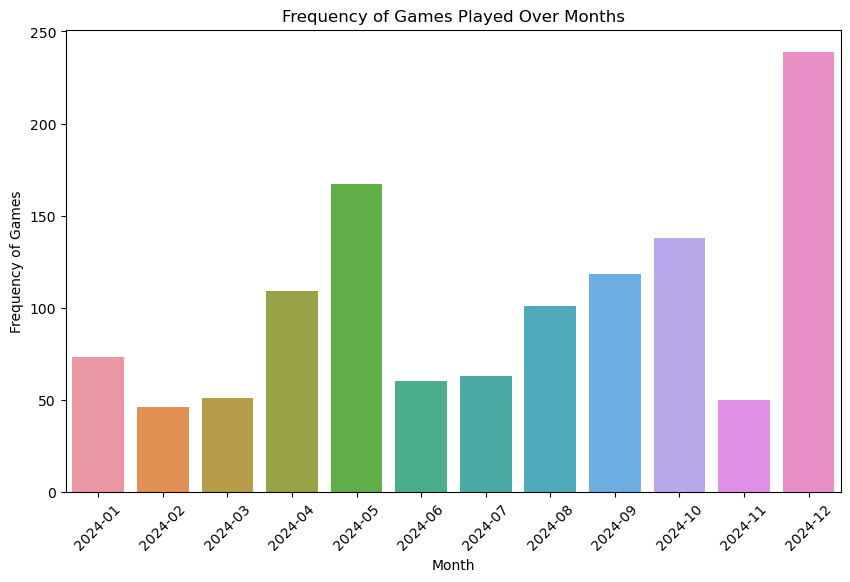

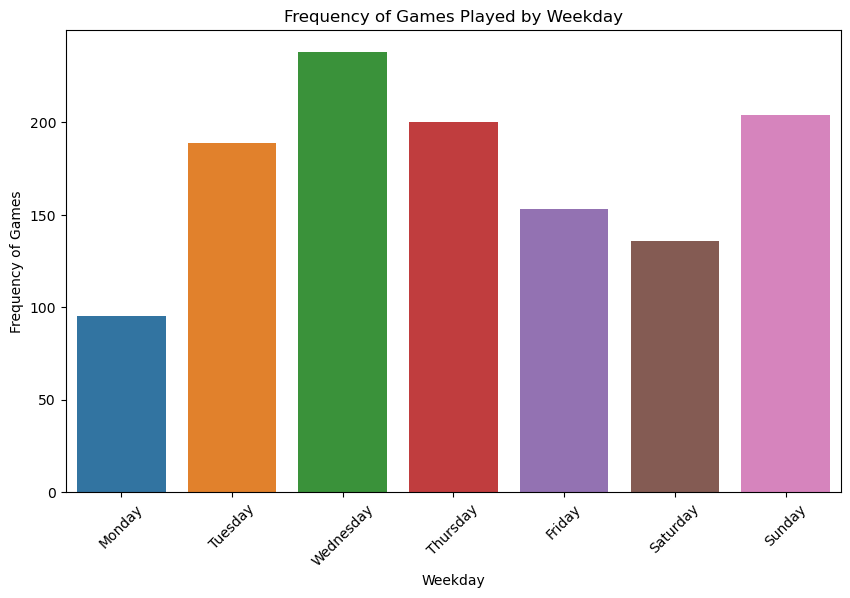

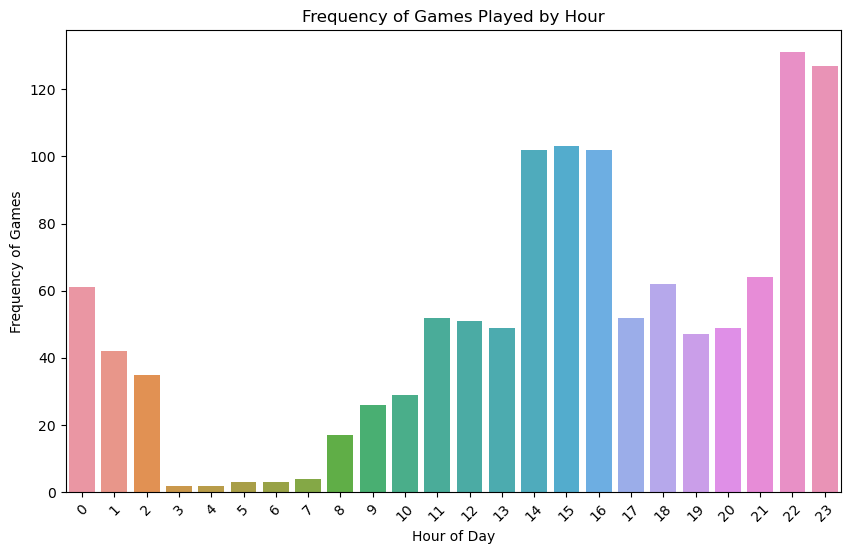

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure that 'timestamp' column is a datetime object
# Assuming 'timestamp' is the column representing the date of each game
cleaned_df['timestamp'] = pd.to_datetime(cleaned_df['date'])

# Extract the month and year from the 'timestamp' column
cleaned_df['month'] = cleaned_df['timestamp'].dt.to_period('M')

# Extract the weekday (0 = Monday, 6 = Sunday)
cleaned_df['weekday'] = cleaned_df['timestamp'].dt.day_name()

# Extract the hour of the day
#print(cleaned_df['start_time'])
cleaned_df['hour'] = cleaned_df['start_time_est'].str.split(':').str[0].astype(int)


# 1. Count the frequency of games played each month
monthly_counts = cleaned_df['month'].value_counts().sort_index()

# 2. Count the frequency of games played by weekday
weekday_counts = cleaned_df['weekday'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# 3. Count the frequency of games played by hour
hourly_counts = cleaned_df['hour'].value_counts().sort_index()

# Plotting the frequency of games over months
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values)
plt.title('Frequency of Games Played Over Months')
plt.xlabel('Month')
plt.ylabel('Frequency of Games')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.savefig(f"{output_dir}Frequency_Year.png")
plt.show()



# Plotting the frequency of games by weekday
plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values)
plt.title('Frequency of Games Played by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Frequency of Games')
plt.xticks(rotation=45)
plt.savefig(f"{output_dir}Frequency_Months.png")
plt.show()




# Plotting the frequency of games by hour
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_counts.index.astype(str), y=hourly_counts.values)
plt.title('Frequency of Games Played by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency of Games')
plt.xticks(rotation=45)
plt.savefig(f"{output_dir}Frequency_Hours.png")
plt.show()






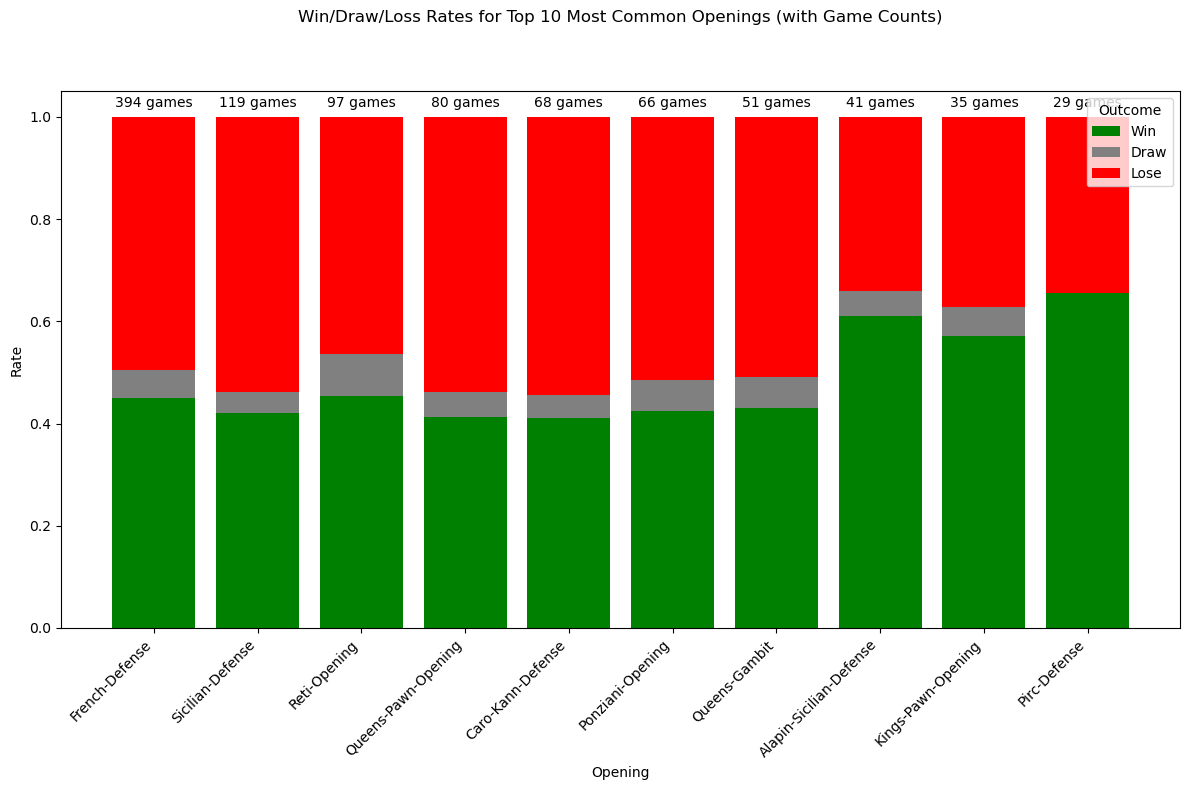

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by 'opening' and 'my_win_or_lose' to count occurrences
opening_stats = cleaned_df.groupby(['eco', 'my_win_or_lose']).size().unstack(fill_value=0)

# Calculate total games per opening
opening_stats['total'] = opening_stats.sum(axis=1)


# Sort by the total number of games played and keep only the top 10
top_10_openings = opening_stats.sort_values(by='total', ascending=False).head(10)

# Normalize the stats to get win, draw, and loss rates
top_10_openings_normalized = top_10_openings.div(top_10_openings['total'], axis=0).drop(columns=['total'])

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for win, draw, and lose
color_map = {'win': 'green', 'draw': 'gray', 'lose': 'red'}

# Plot each segment
bottom = None
for outcome in ['win', 'draw', 'lose']:
    if bottom is None:
        bottom = top_10_openings_normalized[outcome]
        ax.bar(top_10_openings.index, top_10_openings_normalized[outcome], label=outcome.capitalize(), color=color_map[outcome])
    else:
        ax.bar(top_10_openings.index, top_10_openings_normalized[outcome], bottom=bottom, label=outcome.capitalize(), color=color_map[outcome])
        bottom += top_10_openings_normalized[outcome]

# Add game counts as labels above the bars
for idx, total_games in enumerate(top_10_openings['total']):
    ax.text(idx, 1.02, f'{int(total_games)} games', ha='center', fontsize=10, color='black')

# Customize the plot
plt.title('Win/Draw/Loss Rates for Top 10 Most Common Openings (with Game Counts)', pad=50)
plt.xlabel('Opening')
plt.ylabel('Rate')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.legend(title='Outcome', loc='upper right')
plt.tight_layout()

# Show the plot
plt.savefig(f"{output_dir}Openings_GameOutcome.png")
plt.show()




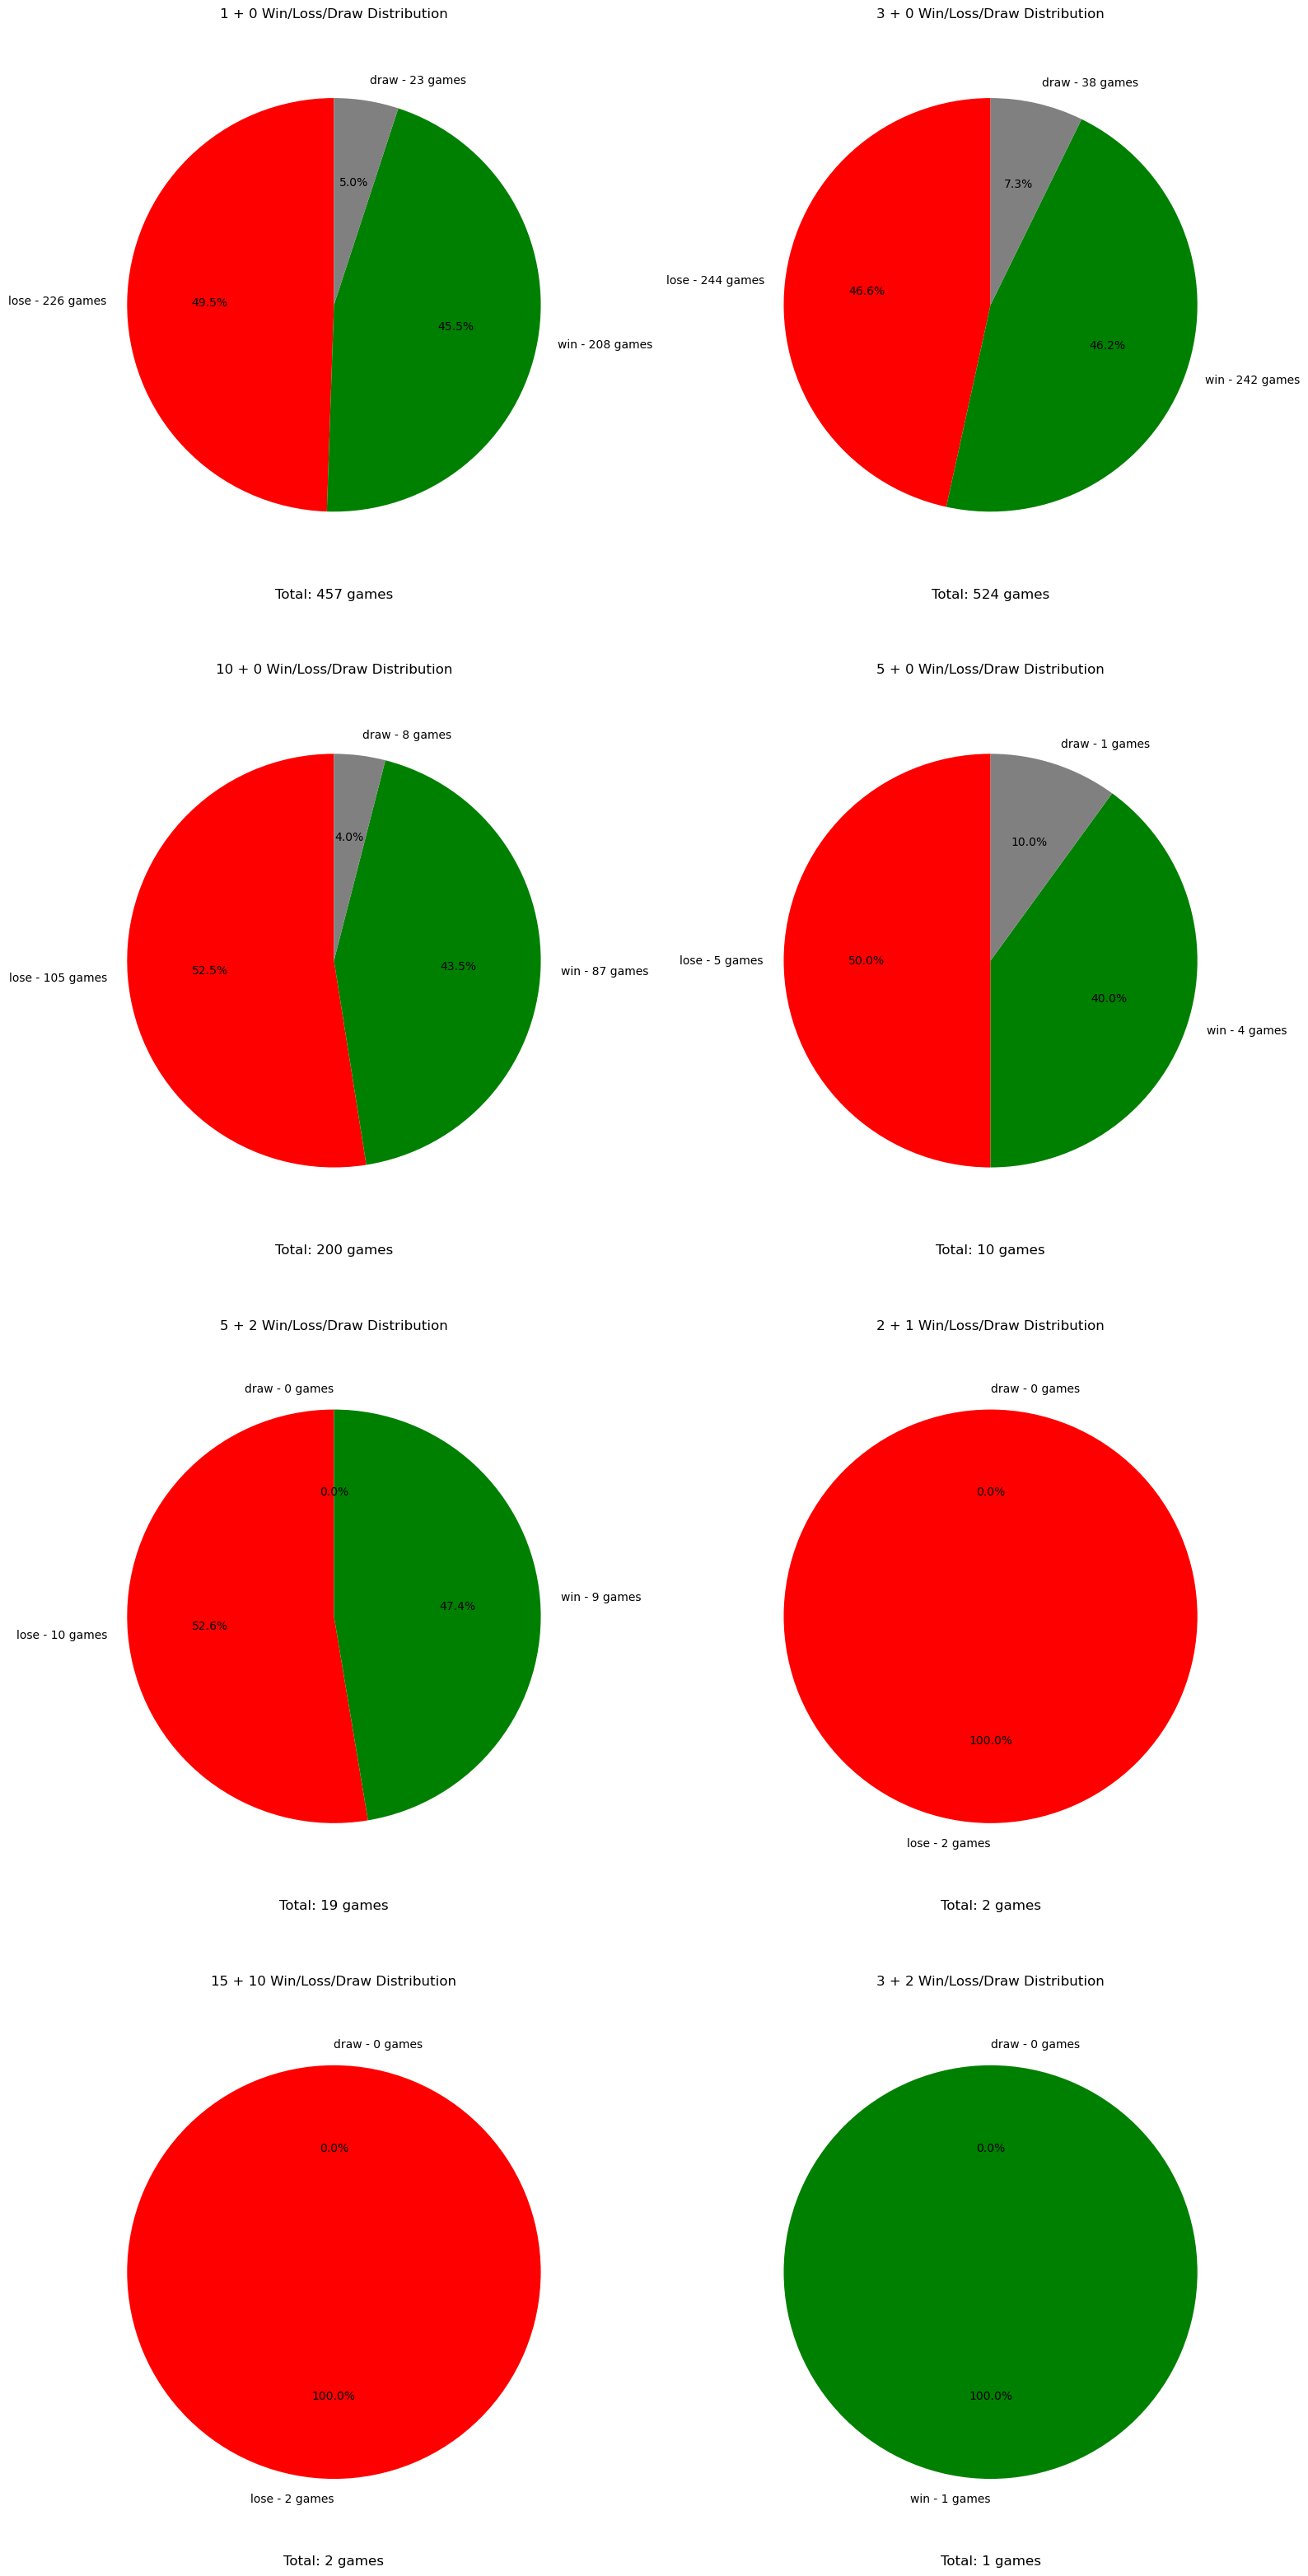

In [18]:
import matplotlib.pyplot as plt

# Get unique time_controls
time_controls = cleaned_df['time_control'].unique()

# Set up the number of columns (e.g., 4 columns per row)
n_cols = 2  # Set number of columns to 4 (you can adjust this)
n_rows = (len(time_controls) + n_cols - 1) // n_cols  # Calculate number of rows dynamically

# Set up the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 8))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array to make indexing easier

# Define custom colors: Green for win, Red for loss, Gray for draw
color_map = {'win': 'green', 'lose': 'red', 'draw': 'gray'}

# Loop through each time_control and plot the pie chart
for i, time_control in enumerate(time_controls):
    # Filter the DataFrame for the current time_control
    time_control_data = cleaned_df[cleaned_df['time_control'] == time_control]
    
    # Count the occurrences of 'my_win_or_lose' for that time_control
    win_loss_counts = time_control_data['my_win_or_lose'].value_counts()
    
    # Ensure 'draw' is included if it's missing in the data for that time_control
    if 'draw' not in win_loss_counts:
        win_loss_counts['draw'] = 0
    
    # Define colors based on outcomes
    colors = [color_map[result] for result in win_loss_counts.index]
    
    # Create labels with both count and percentage
    total_games = len(time_control_data)
    labels = [f'{result} - {count} games' for result, count in zip(win_loss_counts.index, win_loss_counts)]
    # Add total games count at the bottom of the chart
    label_text = f'Total: {total_games} games'
    
    # Plot a pie chart for the current time_control
    ax = axes[i]  # Use the i-th axis in the flattened axes array
    wedges, texts, autotexts = ax.pie(win_loss_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    
    # Set title
    ax.set_title(f'{time_control} Win/Loss/Draw Distribution')
    
    # Adjust the label text position for the pie chart
    ax.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
    
    # Add total games label below the pie chart
    ax.text(0, -1.4, label_text, ha='center', va='center', fontsize=12, color='black')

# Adjust layout for better spacing between charts
plt.tight_layout()

# Display the pie charts
plt.savefig(f"{output_dir}TimeControl_Pi_GameOutcome.png")
plt.show()




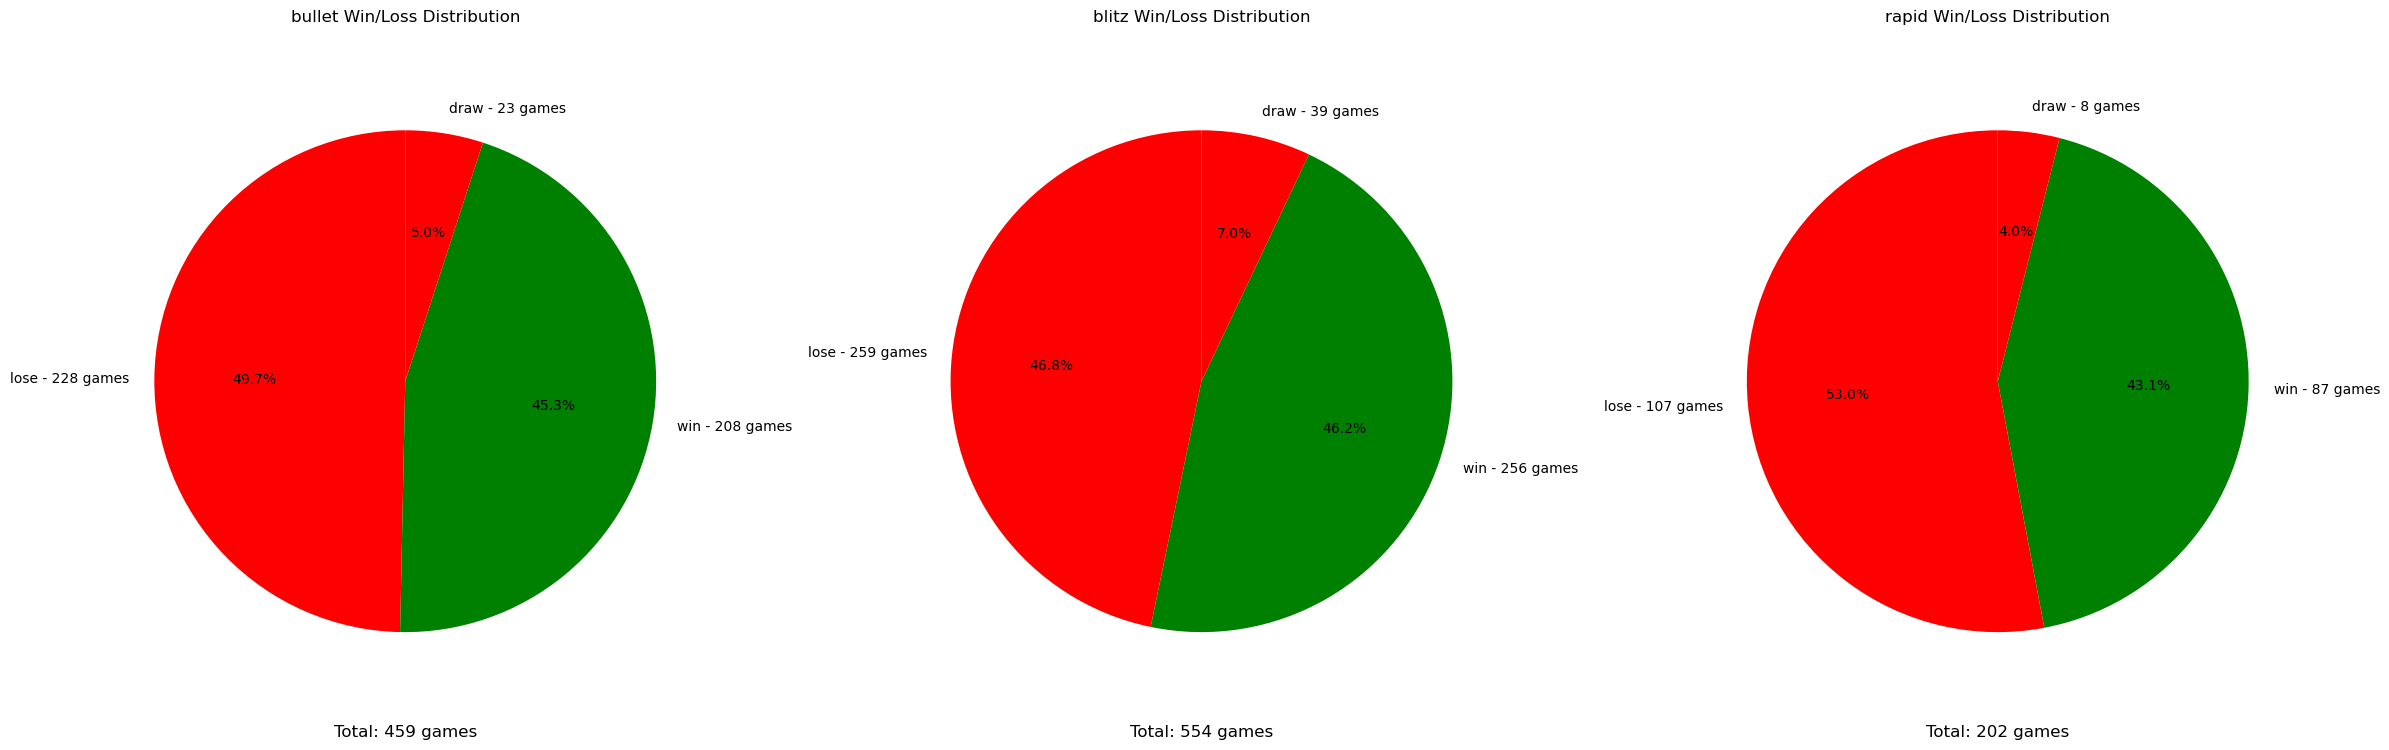

In [19]:
import matplotlib.pyplot as plt

# Get unique time_classes
time_classes = cleaned_df['time_class'].unique()

# Set up the number of rows and columns for the subplots
n_cols = len(time_classes)  # Create one subplot per time_class
n_rows = 1  # All in one row
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, 8))  # Adjust figsize as needed

# Loop through each time_class and plot the pie chart
for i, time_class in enumerate(time_classes):
    # Filter the DataFrame for the current time_class
    time_class_data = cleaned_df[cleaned_df['time_class'] == time_class]
    
    # Count the occurrences of 'my_win_or_lost' for that time_class
    win_loss_counts = time_class_data['my_win_or_lose'].value_counts()
    
    # Define custom colors (green for win, red for loss)
    colors = ['green' if result == 'win' else 'red' for result in win_loss_counts.index]
    
    # Create labels with both count and percentage
    total_games = len(time_class_data)
    labels = [f'{result} - {count} games' for result, count in zip(win_loss_counts.index, win_loss_counts)]
    # Add total games count at the bottom of the chart
    label_text = f'Total: {total_games} games'
    
    # Plot a pie chart for the current time_class
    ax = axes[i] if n_cols > 1 else axes  # Adjust axes indexing based on the number of columns
    wedges, texts, autotexts = ax.pie(win_loss_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    
    # Set title  
    ax.set_title(f'{time_class} Win/Loss Distribution')
    
    # Adjust the label text position for the pie chart
    ax.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
    3
    # Add total games label below the pie chart
    ax.text(0, -1.4, label_text, ha='center', va='center', fontsize=12, color='black')

# Adjust layout for better spacing between charts
plt.tight_layout()

# Display the pie charts side by side
plt.savefig(f"{output_dir}GameOutcome_TimeClass_PiCharts.png")
plt.show()


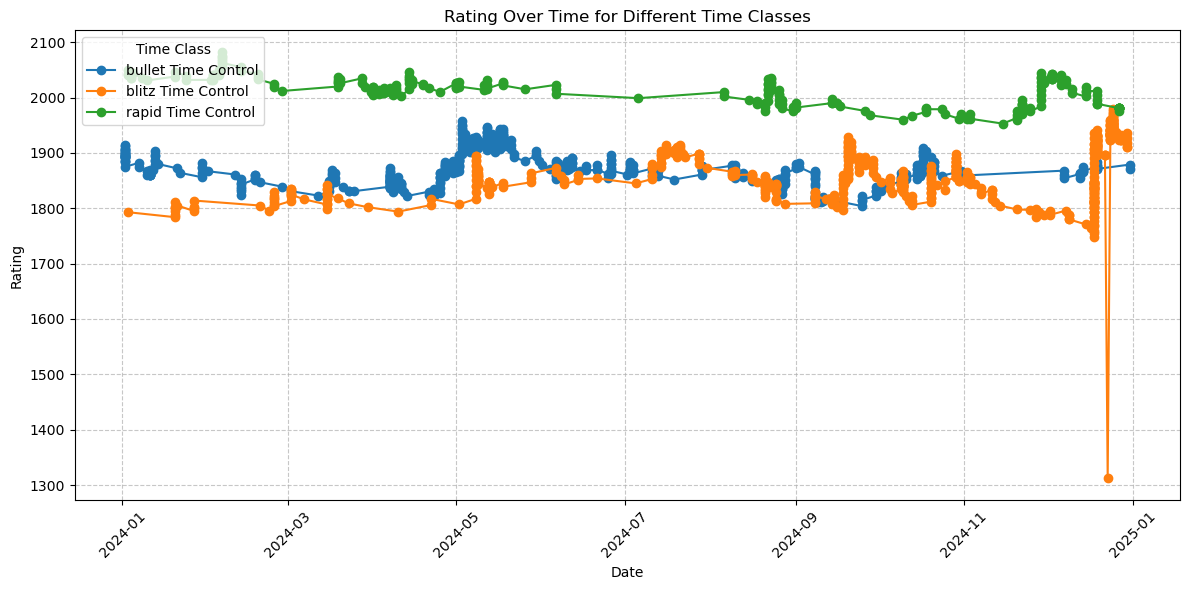

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' is in datetime format
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'], errors='coerce')

# Filter rows where 'my_rating' exists and drop rows with missing dates
rating_data = cleaned_df.dropna(subset=['my_rating', 'date'])

# Get unique time_classes
time_classes = rating_data['time_class'].unique()

# Plot rating over time for each time_class
plt.figure(figsize=(12, 6))

# Loop over each time_class and plot its data
for time_class in time_classes:
    time_class_data = rating_data[rating_data['time_class'] == time_class]
    plt.plot(time_class_data['date'], time_class_data['my_rating'], marker='o', label=f"{time_class} Time Control")

# Customize the plot
plt.title('Rating Over Time for Different Time Classes')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Time Class', loc='upper left')

# Adjust layout for better display
plt.tight_layout()

# Display the plot
plt.savefig(f"{output_dir}RatingOverTime.png")
plt.show()





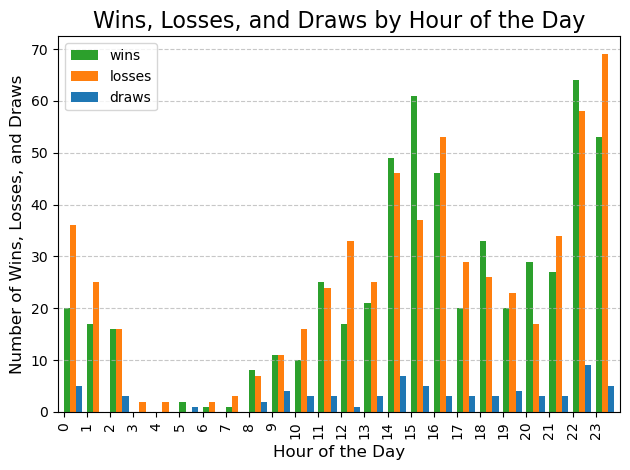

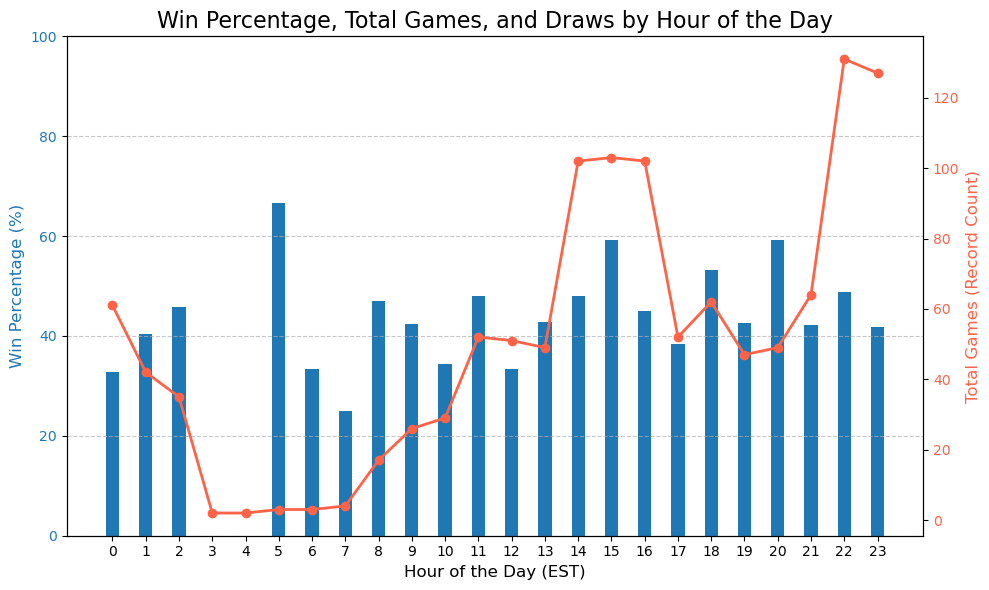

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter rows for wins, losses, and draws
wins_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].copy()
losses_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].copy()
draws_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'draw'].copy()

# Convert 'start_time_est' to datetime and extract the hour
wins_data['start_time_est'] = pd.to_datetime(wins_data['start_time_est'], format='%H:%M:%S')
losses_data['start_time_est'] = pd.to_datetime(losses_data['start_time_est'], format='%H:%M:%S')
draws_data['start_time_est'] = pd.to_datetime(draws_data['start_time_est'], format='%H:%M:%S')

# Extract the hour from the 'start_time_est' column
wins_data['hour'] = wins_data['start_time_est'].dt.hour
losses_data['hour'] = losses_data['start_time_est'].dt.hour
draws_data['hour'] = draws_data['start_time_est'].dt.hour

# Group by hour and count the wins, losses, and draws
hourly_wins = wins_data.groupby('hour').size()
hourly_losses = losses_data.groupby('hour').size()
hourly_draws = draws_data.groupby('hour').size()

# Combine the wins, losses, and draws into a single DataFrame for easier plotting
hourly_counts = pd.DataFrame({
    'wins': hourly_wins,
    'losses': hourly_losses,
    'draws': hourly_draws
}).fillna(0)  # Fill missing values with 0 (some hours may have no wins, losses, or draws)

# Plot the side-by-side bar chart with improved color scheme
ax = hourly_counts.plot(kind='bar', width=0.8, color=['#2ca02c', '#ff7f0e', '#1f77b4'], position=0)

# Customize the plot for better visual appeal
plt.title('Wins, Losses, and Draws by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Wins, Losses, and Draws', fontsize=12)
plt.xticks(range(0, 24), fontsize=10)  # Show every hour on the x-axis
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.savefig(f"{output_dir}GameOutcome_HourofDay1.png")
plt.show()



# Calculate total games and win percentages for each hour
hourly_totals = hourly_wins.add(hourly_losses, fill_value=0).add(hourly_draws, fill_value=0)
hourly_win_percentage = (hourly_wins / hourly_totals) * 100

# Create the plot with dual axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the win percentage on the first axis as a bar chart
ax1.bar(hourly_win_percentage.index, hourly_win_percentage, width=0.4, color='#1f77b4', label='Win Percentage')
ax1.set_xlabel('Hour of the Day (EST)', fontsize=12)
ax1.set_ylabel('Win Percentage (%)', color='#1f77b4', fontsize=12)
ax1.set_ylim(0, 100)  # Percentage ranges from 0 to 100
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.set_xticks(range(0, 24))  # Show every hour on the x-axis
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Create a second axis to plot the total games (record count) as a line chart
ax2 = ax1.twinx()
ax2.plot(hourly_totals.index, hourly_totals, color='#ff6347', marker='o', label='Total Games', linewidth=2)
ax2.set_ylabel('Total Games (Record Count)', color='#ff6347', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#ff6347')

# Add a title and display the plot
plt.title('Win Percentage, Total Games, and Draws by Hour of the Day', fontsize=16)
fig.tight_layout()  # Ensure everything fits without overlap

# Show the plot
plt.savefig(f"{output_dir}GameOutcome_HourofDay2.png")

plt.show()


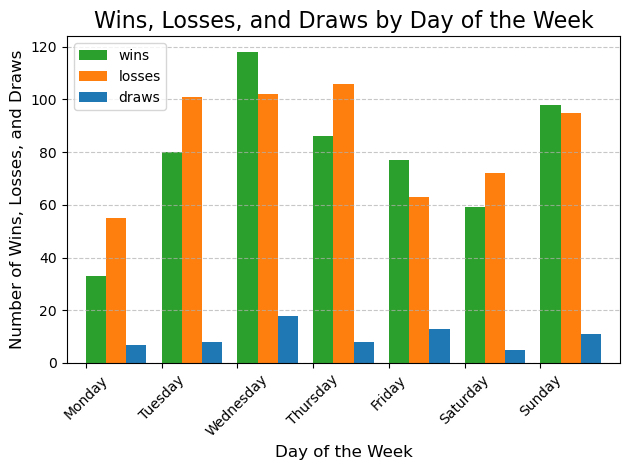

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' is in datetime format
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

# Filter rows for wins, losses, and draws
wins_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].copy()
losses_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].copy()
draws_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'draw'].copy()

# Extract the day of the week from the 'date' column
wins_data['day_of_week'] = wins_data['date'].dt.day_name()  # Get day name (e.g., 'Monday')
losses_data['day_of_week'] = losses_data['date'].dt.day_name()  # Get day name (e.g., 'Monday')
draws_data['day_of_week'] = draws_data['date'].dt.day_name()  # Get day name (e.g., 'Monday')

# Group by day of the week and count the wins, losses, and draws
hourly_wins = wins_data.groupby('day_of_week').size()
hourly_losses = losses_data.groupby('day_of_week').size()
hourly_draws = draws_data.groupby('day_of_week').size()

# Reorder days of the week to ensure proper ordering in the plot
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a DataFrame combining wins, losses, and draws
hourly_counts = pd.DataFrame({
    'wins': hourly_wins,
    'losses': hourly_losses,
    'draws': hourly_draws
}).fillna(0)  # Fill missing values with 0 (some days may have no wins, losses, or draws)

# Reorder the rows based on the days of the week to ensure the correct order
hourly_counts = hourly_counts.reindex(days_order)

# Plot the side-by-side bar chart with improved color scheme
ax = hourly_counts.plot(kind='bar', width=0.8, color=['#2ca02c', '#ff7f0e', '#1f77b4'], position=0)

# Customize the plot for better visual appeal
plt.title('Wins, Losses, and Draws by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Wins, Losses, and Draws', fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.savefig(f"{output_dir}GameOutcome_DayofWeek.png")
plt.show()


/var/folders/39/n8p80q7s1b13_khp67kt_dlw0000gn/T/ipykernel_93427/3187031381.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_counts = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].groupby(['opp_rating_range', 'time_class']).size()
/var/folders/39/n8p80q7s1b13_khp67kt_dlw0000gn/T/ipykernel_93427/3187031381.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_counts = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].groupby(['opp_rating_range', 'time_class']).size()


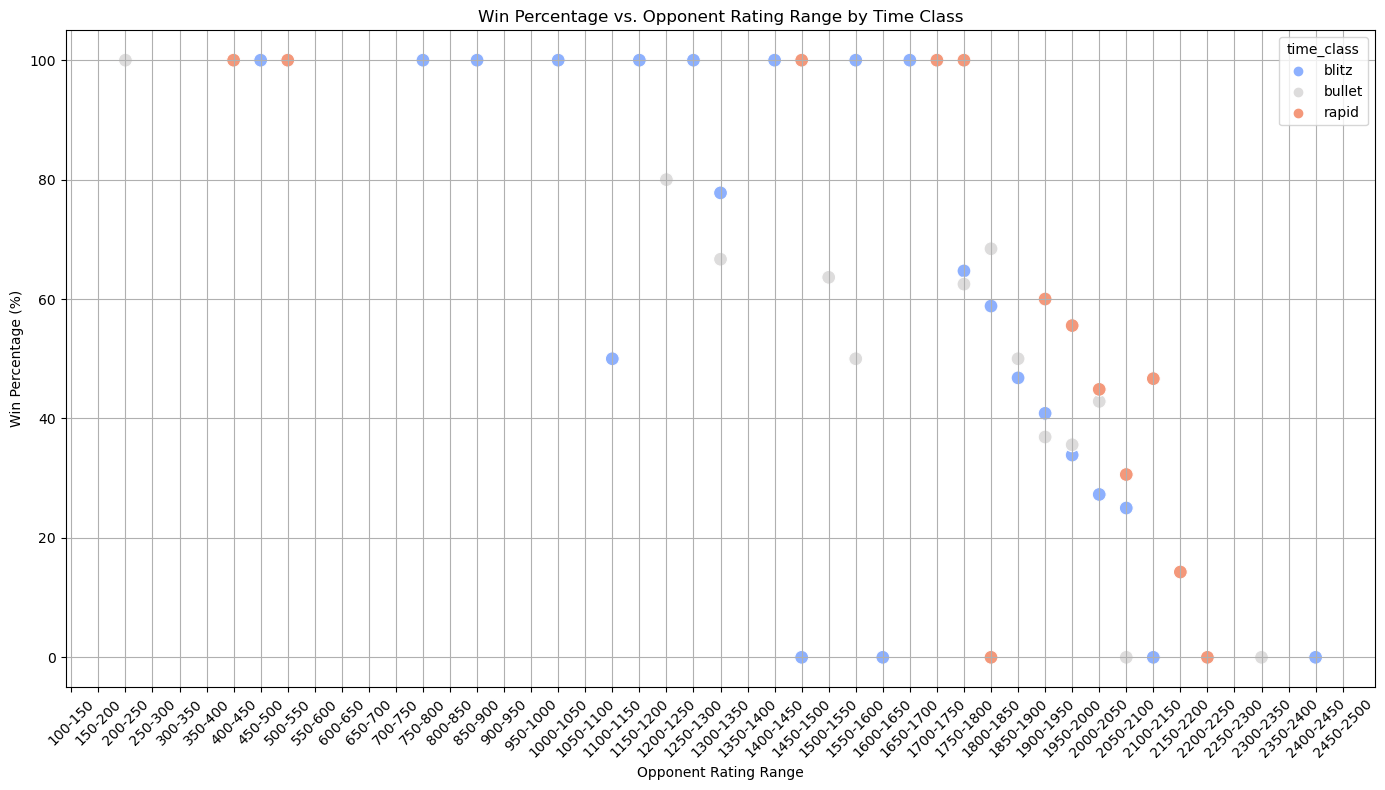

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create bins for 'opp_rating' from 0 to 2500, with intervals of 50
rating_bins = list(range(0, 2550, 50))  # Bins from 0 to 2500, with step 50
rating_labels = [f'{i}-{i+50}' for i in range(0, 2500, 50)]  # Create labels for each bin range

# Assuming 'opp_rating' is available in the dataframe and represents the opponent's rating
cleaned_df['opp_rating_range'] = pd.cut(cleaned_df['opp_rating'], bins=rating_bins, labels=rating_labels)

# Calculate wins and losses by opponent rating range and time control type
win_counts = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].groupby(['opp_rating_range', 'time_class']).size()
loss_counts = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].groupby(['opp_rating_range', 'time_class']).size()

# Combine win and loss counts
game_counts = win_counts.add(loss_counts, fill_value=0)

# Calculate win percentage
win_percentage = win_counts / game_counts * 100
win_percentage = win_percentage.reset_index(name='win_percentage')

# Create the scatterplot
plt.figure(figsize=(14, 8))
sns.scatterplot(x='opp_rating_range', y='win_percentage', hue='time_class', data=win_percentage, palette='coolwarm', s=100)
plt.title('Win Percentage vs. Opponent Rating Range by Time Class')
plt.xlabel('Opponent Rating Range')
plt.ylabel('Win Percentage (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}GameOutcome_OppRating.png")
plt.show()



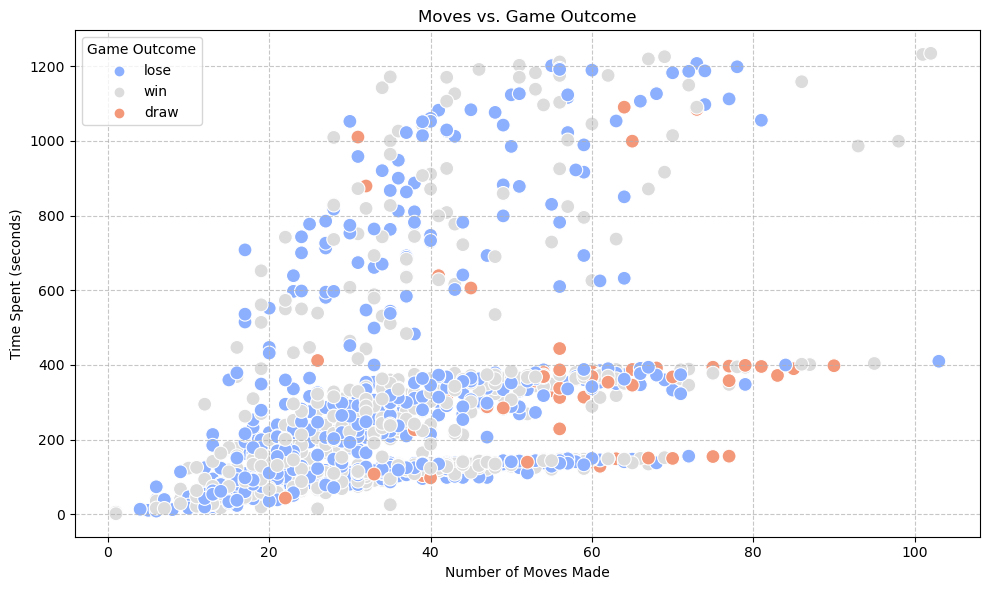

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter rows where 'moves_made', 'time_spent', and 'my_win_or_lose' exist
filtered_data = cleaned_df[['my_num_moves', 'time_spent', 'my_win_or_lose']].dropna()

# Set plot size
plt.figure(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(x='my_num_moves', y='time_spent', hue='my_win_or_lose', data=filtered_data, palette='coolwarm', s=100)

# Customize the plot
plt.title('Moves vs. Game Outcome')
plt.xlabel('Number of Moves Made')
plt.ylabel('Time Spent (seconds)')
plt.legend(title='Game Outcome')
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.savefig(f"{output_dir}Moves_GameOutcome_Scatterplot.png")  # Save the plot

plt.show()



/var/folders/39/n8p80q7s1b13_khp67kt_dlw0000gn/T/ipykernel_93427/1963809660.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_data = filtered_data.groupby('moves_bin_lower').agg(


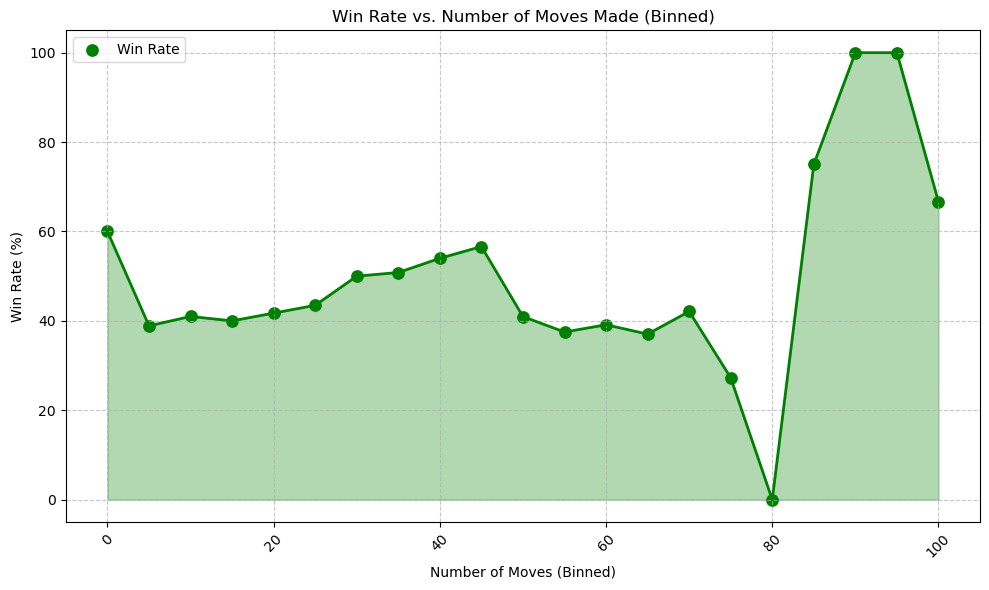

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter rows where 'my_num_moves', 'time_spent', and 'my_win_or_lose' exist
filtered_data = cleaned_df[['my_num_moves', 'time_spent', 'my_win_or_lose']].dropna()

# Create bins for moves (group by 5-move intervals)
bins = range(0, filtered_data['my_num_moves'].max() + 5, 5)
filtered_data['moves_bin'] = pd.cut(filtered_data['my_num_moves'], bins=bins)

# Convert 'moves_bin' intervals to the lower bound of the bin for plotting
filtered_data['moves_bin_lower'] = filtered_data['moves_bin'].apply(lambda x: x.left)

# Group by the move bins and calculate win rate (win_count / total_games)
win_rate_data = filtered_data.groupby('moves_bin_lower').agg(
    win_count=('my_win_or_lose', lambda x: (x == 'win').sum()),
    total_games=('my_win_or_lose', 'count')
).reset_index()

# Calculate win rate as percentage
win_rate_data['win_percentage'] = (win_rate_data['win_count'] / win_rate_data['total_games']) * 100

# Set plot size
plt.figure(figsize=(10, 6))

# Plot win rate as dots and connect them with a line
sns.scatterplot(x='moves_bin_lower', y='win_percentage', data=win_rate_data, color='green', s=100, label='Win Rate')
plt.plot(win_rate_data['moves_bin_lower'], win_rate_data['win_percentage'], color='green', linestyle='-', linewidth=2)

# Add shading below the curve
plt.fill_between(win_rate_data['moves_bin_lower'], win_rate_data['win_percentage'], color='green', alpha=0.3)

# Customize the plot
plt.title('Win Rate vs. Number of Moves Made (Binned)')
plt.xlabel('Number of Moves (Binned)')
plt.ylabel('Win Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.savefig(f"{output_dir}WinRate_NumOfMoves.png")  # Save the plot
plt.show()


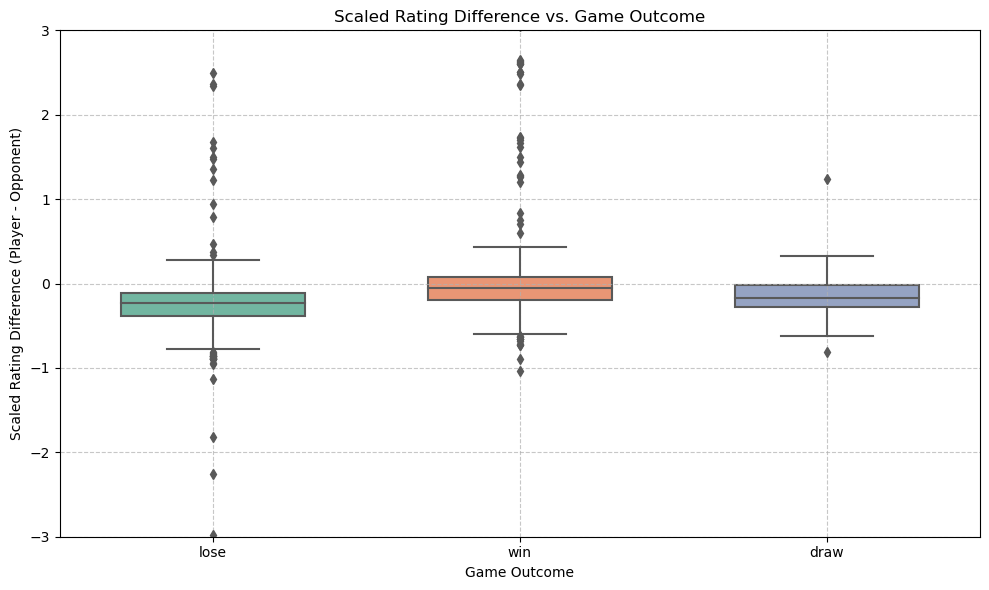

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Create a new column for rating difference
cleaned_df['rating_difference'] = cleaned_df['my_rating'] - cleaned_df['opp_rating']

# Filter out rows where rating difference or my_win_or_lose is missing
filtered_data = cleaned_df[['rating_difference', 'my_win_or_lose']].dropna()

# Standardize the rating_difference column
scaler = StandardScaler()
filtered_data['scaled_rating_difference'] = scaler.fit_transform(filtered_data[['rating_difference']])

# Set plot size
plt.figure(figsize=(10, 6))

# Create a boxplot for scaled rating difference by game outcome with wider boxes
sns.boxplot(x='my_win_or_lose', y='scaled_rating_difference', data=filtered_data, palette='Set2', width=0.6)

# Customize the plot
plt.title('Scaled Rating Difference vs. Game Outcome')
plt.xlabel('Game Outcome')
plt.ylabel('Scaled Rating Difference (Player - Opponent)')

# Adjust the y-axis limits to emphasize a specific range
plt.ylim(-3, 3)  # You can change these values to whatever makes sense for your data

plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.savefig(f"{output_dir}RatingDiff_GameOutcome_BoxPlot.png")  # Save the plot
plt.show()




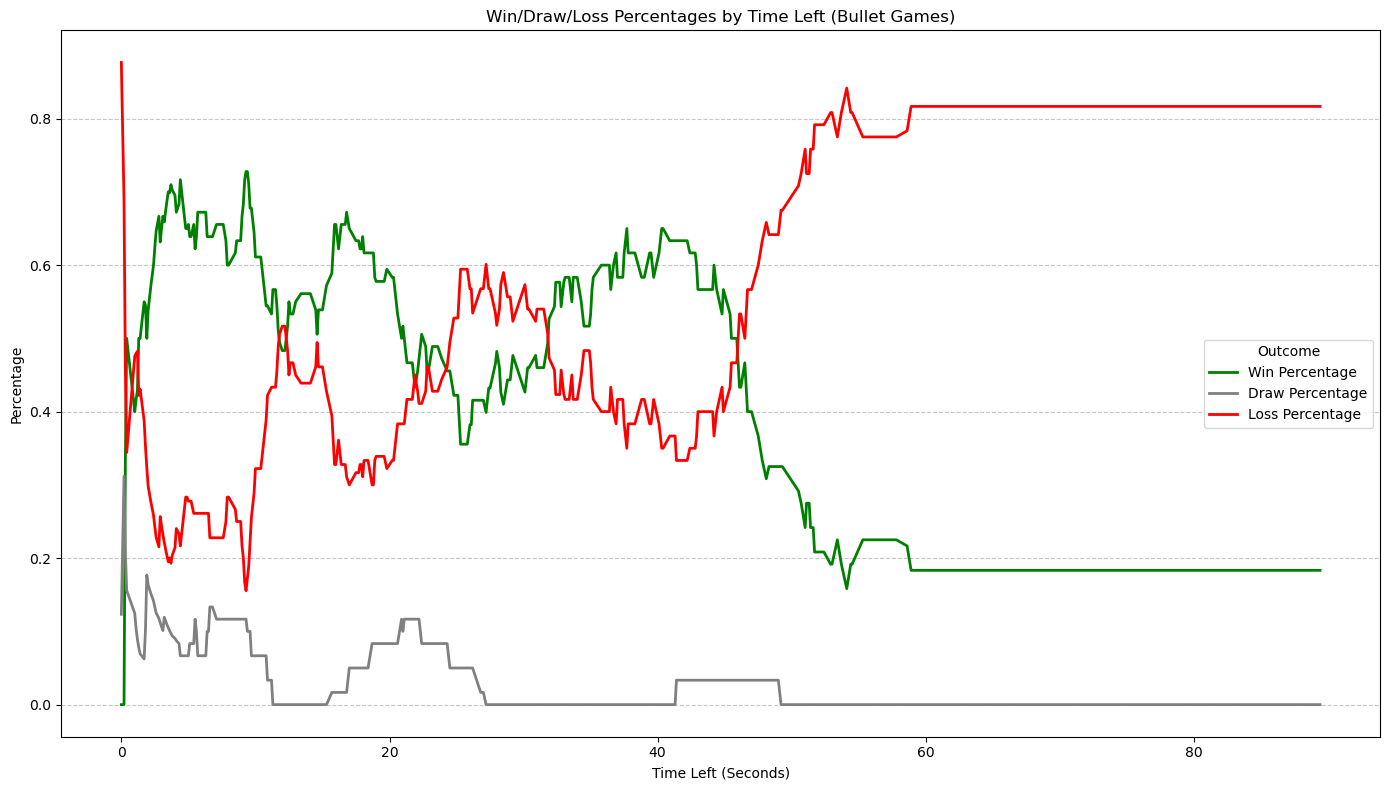

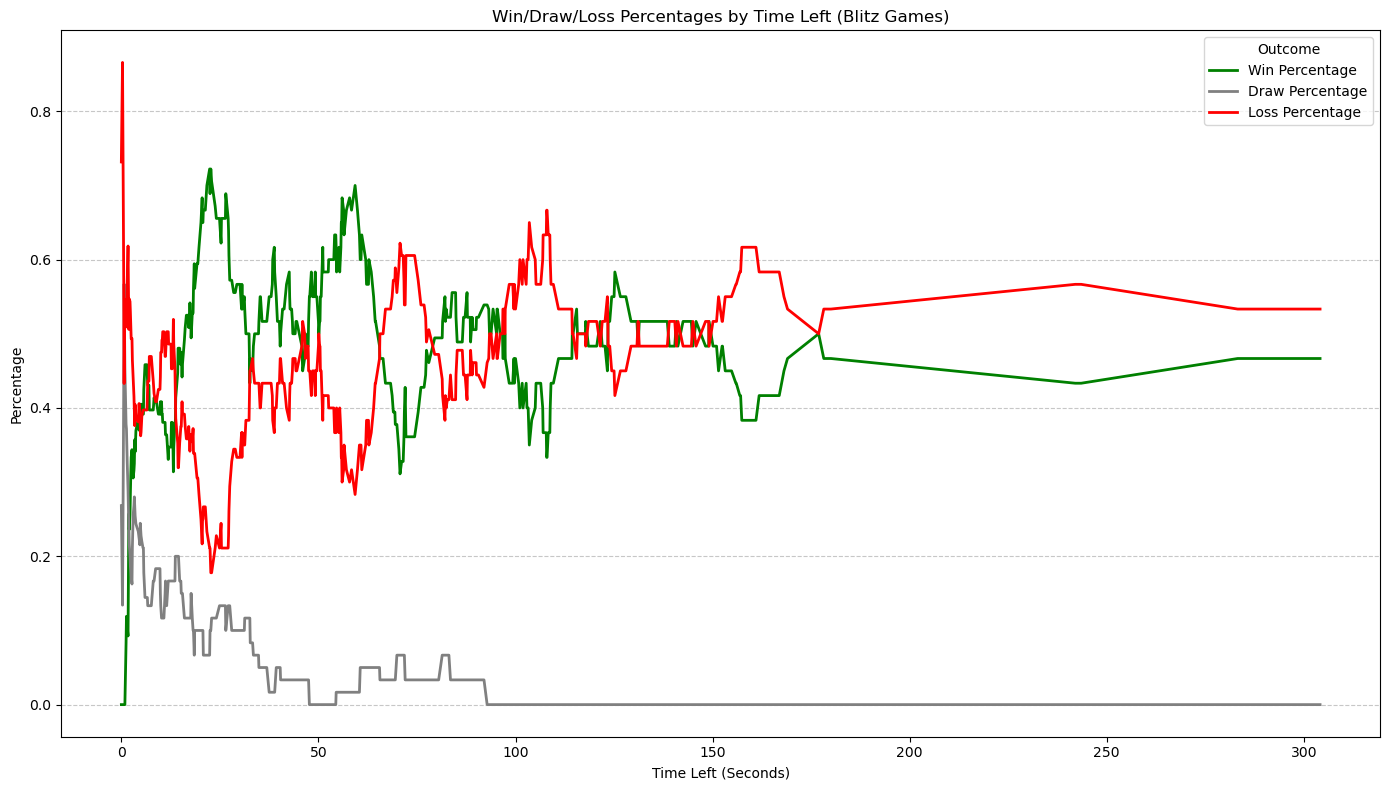

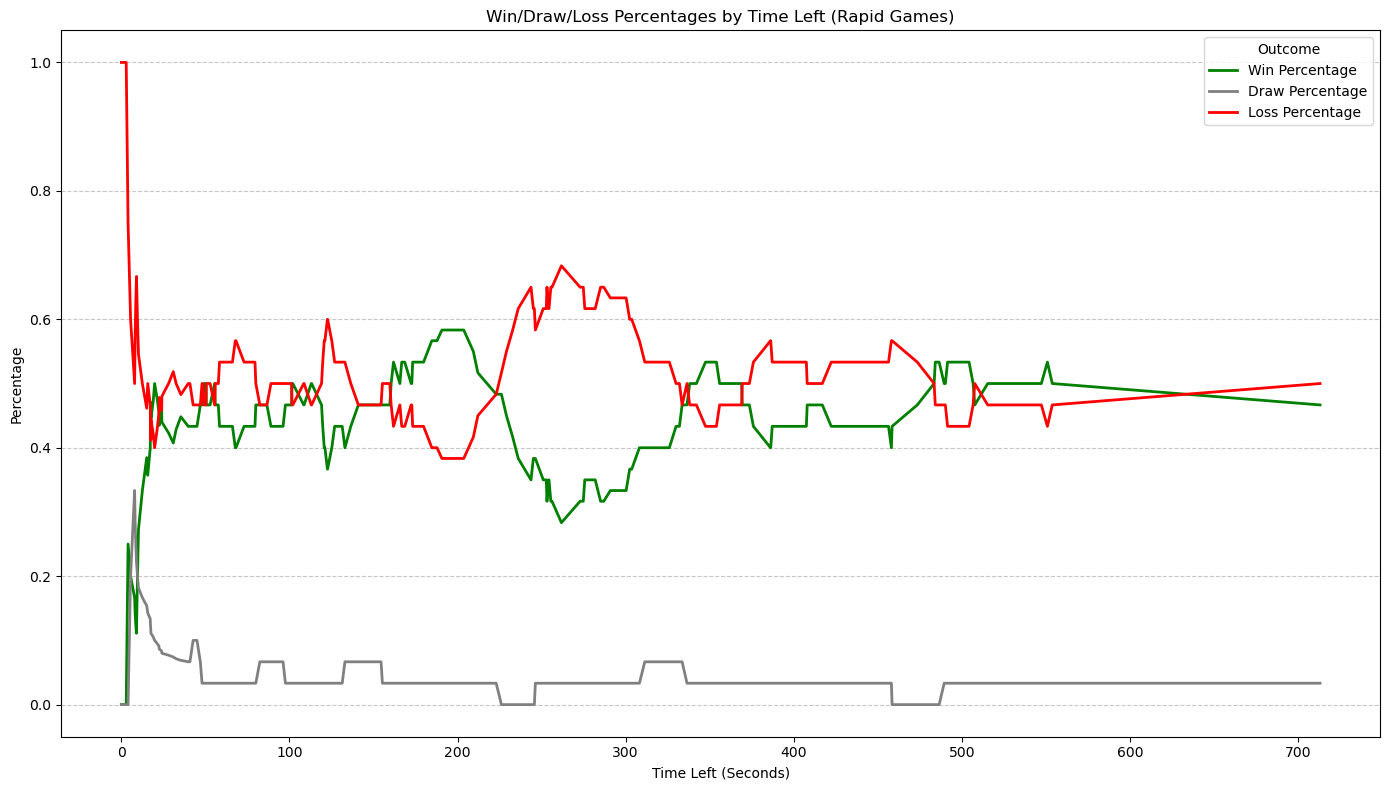

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'time_left' is sorted
cleaned_df = cleaned_df.sort_values('my_time_left')

# Define time controls
time_controls = ['bullet', 'blitz', 'rapid']

# Plot for each time control
for time_control in time_controls:
    # Filter the data for the current time control
    filtered_df = cleaned_df[cleaned_df['time_class'] == time_control]

    # Group by 'time_left' and calculate outcome counts
    time_stats = filtered_df.groupby(['my_time_left', 'my_win_or_lose']).size().unstack(fill_value=0)

    # Calculate total games for each time_left
    time_stats['total'] = time_stats.sum(axis=1)

    # Calculate percentages for each outcome
    time_stats_normalized = time_stats.div(time_stats['total'], axis=0).drop(columns=['total'])

    # Smooth the data for better visualization (optional)
    time_left = time_stats_normalized.index
    # Check if the required columns exist before accessing them
    if 'win' in time_stats_normalized.columns:
        win_percent = time_stats_normalized['win'].rolling(window=30, min_periods=1).mean()
    else:
        win_percent = pd.Series([0] * len(time_stats_normalized))  # Default to 0 if no 'win' data
    
    # Handle 'draw' and 'lose' similarly
    if 'draw' in time_stats_normalized.columns:
        draw_percent = time_stats_normalized['draw'].rolling(window=30, min_periods=1).mean()
    else:
        draw_percent = pd.Series([0] * len(time_stats_normalized))
    
    if 'lose' in time_stats_normalized.columns:
        lose_percent = time_stats_normalized['lose'].rolling(window=30, min_periods=1).mean()
    else:
        lose_percent = pd.Series([0] * len(time_stats_normalized))
    # Plot the line chart
    plt.figure(figsize=(14, 8))
    plt.plot(time_left, win_percent, label='Win Percentage', color='green', linewidth=2)
    plt.plot(time_left, draw_percent, label='Draw Percentage', color='gray', linewidth=2)
    plt.plot(time_left, lose_percent, label='Loss Percentage', color='red', linewidth=2)

    # Customize the plot
    plt.title(f'Win/Draw/Loss Percentages by Time Left ({time_control.capitalize()} Games)')
    plt.xlabel('Time Left (Seconds)')
    plt.ylabel('Percentage')
    plt.legend(title='Outcome', loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{output_dir}TimeLeft_GameOutcome_BoxPlot_{time_control}.png")  # Save the plot
    plt.show()



In [28]:
# How many Queen Promotions you have (and other promotions?)
# How many en passants you have done
# Win and Loss ratio being white vs black
# Biggest Upset and Biggest Reverse Upset
# Brilliant Moves Finder

In [29]:
# Are you a fair loser? how do u lose

In [30]:
cleaned_df.columns

Index(['url', 'moves', 'date', 'start_time_est', 'end_time_est', 'time_spent',
       'link', 'time_control', 'time_class', 'rated', 'tcn', 'uuid',
       'initial_setup', 'fen', 'rules', 'white_username', 'white_rating',
       'white_result', 'white_metamoves', 'black_username', 'black_rating',
       'black_result', 'black_metamoves', 'eco', 'my_username', 'my_rating',
       'my_result', 'my_win_or_lose', 'my_metamoves', 'opp_username',
       'opp_rating', 'opp_result', 'opp_metamoves', 'my_color', 'my_time_left',
       'opp_time_left', 'my_num_moves', 'my_time_left_ratio',
       'opp_time_left_ratio', 'my_moves', 'opp_moves', 'my_castling',
       'opp_castling', 'en_passant_count', 'promotion_count', 'num_moves',
       'rating_diff', 'timestamp', 'month', 'weekday', 'hour',
       'opp_rating_range', 'rating_difference'],
      dtype='object')

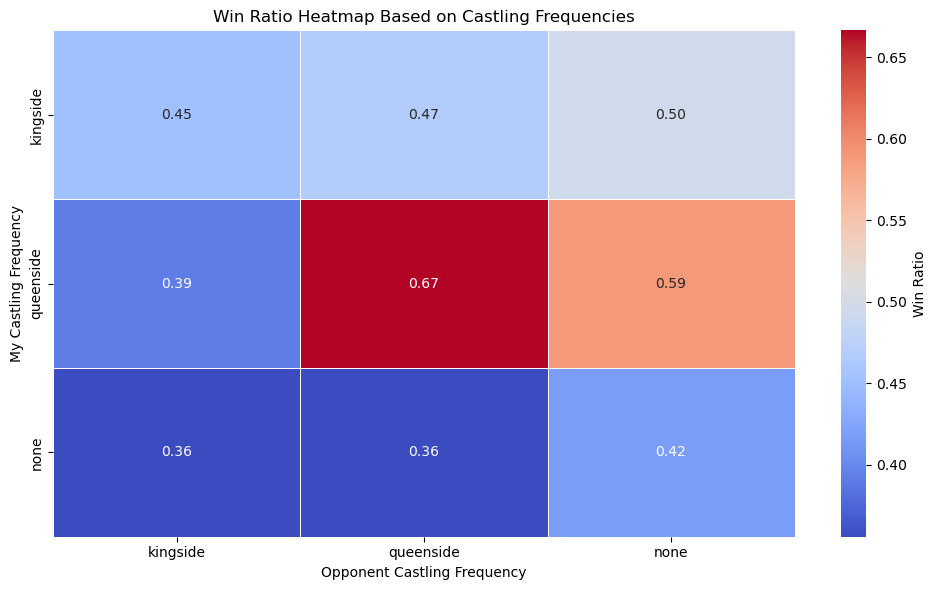

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Filter the data for relevant columns and drop missing values
filtered_data = cleaned_df[['my_castling', 'opp_castling', 'my_win_or_lose']].dropna()

# Create a new column to represent win (1) and loss (0), ignoring draws
filtered_data['win'] = filtered_data['my_win_or_lose'].apply(lambda x: 1 if x == 'win' else 0)

# Create a pivot table to calculate win ratio (wins / total games) for each castling combination
win_ratio_data = filtered_data.groupby(['my_castling', 'opp_castling']).agg(
    win_ratio=('win', 'mean'),
    total_games=('win', 'size')
).reset_index()

# Filter to include only combinations with a certain number of games (e.g., at least 10 games)
win_ratio_data = win_ratio_data[win_ratio_data['total_games'] >= 10]

# Define all possible castling values
castling_values = ['kingside', 'queenside', 'none']

# Reindex the data to ensure all combinations are represented, filling missing values with NaN
heatmap_data = win_ratio_data.pivot(index='my_castling', columns='opp_castling', values='win_ratio')
heatmap_data = heatmap_data.reindex(castling_values, axis=0).reindex(castling_values, axis=1)

# Fill NaN values with 0 (or use any other placeholder you'd like, such as 'NaN' or 'No Data')
heatmap_data = heatmap_data.fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Win Ratio'})

plt.title('Win Ratio Heatmap Based on Castling Frequencies')
plt.xlabel('Opponent Castling Frequency')
plt.ylabel('My Castling Frequency')
plt.tight_layout()
plt.savefig(f"{output_dir}Heatmap_WinRatio_CastlingFrequencies.png")  # Save the plot

plt.show()







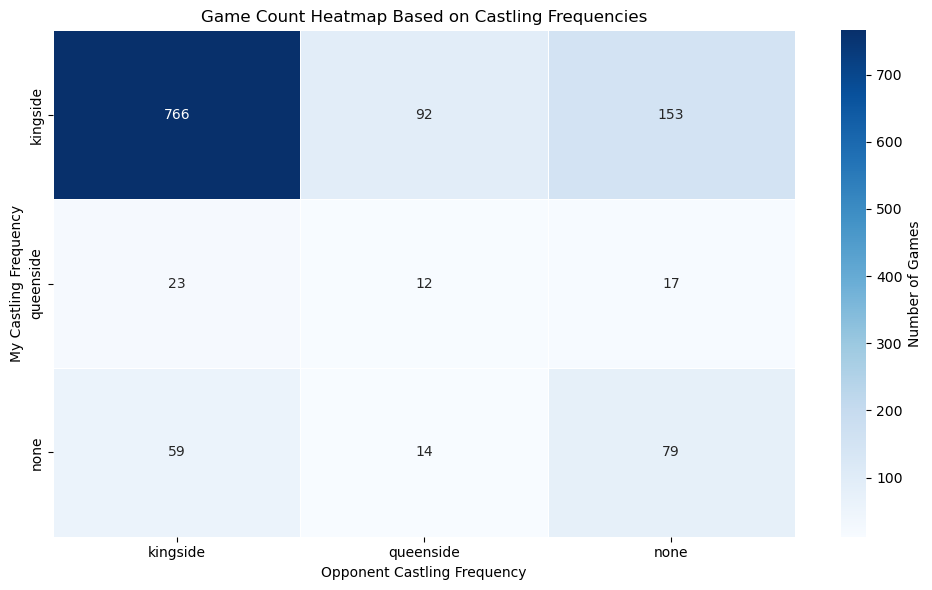

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Filter the data for relevant columns and drop missing values
filtered_data = cleaned_df[['my_castling', 'opp_castling', 'my_win_or_lose']].dropna()

# Create a pivot table to count the number of games for each castling combination
game_count_data = filtered_data.groupby(['my_castling', 'opp_castling']).size().reset_index(name='game_count')

# Define all possible castling values
castling_values = ['kingside', 'queenside', 'none']

# Reindex the data to ensure all combinations are represented, filling missing values with 0
heatmap_data = game_count_data.pivot(index='my_castling', columns='opp_castling', values='game_count')
heatmap_data = heatmap_data.reindex(castling_values, axis=0).reindex(castling_values, axis=1)

# Fill NaN values with 0 (or use any other placeholder you'd like, such as 'NaN' or 'No Data')
heatmap_data = heatmap_data.fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d', linewidths=.5, cbar_kws={'label': 'Number of Games'})

plt.title('Game Count Heatmap Based on Castling Frequencies')
plt.xlabel('Opponent Castling Frequency')
plt.ylabel('My Castling Frequency')
plt.tight_layout()
plt.savefig(f"{output_dir}Heatmap_GameCount_CastlingFrequencies.png")  # Save the plot

plt.show()


In [33]:
'''import os
from PIL import Image
import numpy as np

def combine_images(input_dir="images", output_file="combined_image.png"):
    # Get all PNG files in the specified directory
    png_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.png')]
    
    if not png_files:
        print(f"No PNG files found in the {input_dir} directory.")
        return
    
    # Open all the images
    images = [Image.open(f) for f in png_files]
    
    # Get the maximum width and height of all images
    max_width = max(img.width for img in images)
    max_height = max(img.height for img in images)
    
    # Calculate how many images to arrange in rows and columns
    num_images = len(images)
    rows = int(np.ceil(np.sqrt(num_images)))  # Number of rows (square root of total number of images)
    cols = int(np.ceil(num_images / rows))   # Number of columns
    
    # Create a new blank image large enough to fit all the images
    combined_width = cols * max_width
    combined_height = rows * max_height
    combined_image = Image.new('RGB', (combined_width, combined_height), (255, 255, 255))  # White background
    
    # Paste the images into the new image
    x_offset = 0
    y_offset = 0
    
    for i, img in enumerate(images):
        # Resize image to fit the max width and height, if necessary
        img_resized = img.resize((max_width, max_height))
        
        # Paste the resized image into the correct position
        combined_image.paste(img_resized, (x_offset, y_offset))
        
        # Move the x_offset to the right, and if we exceed the width, move to the next row
        x_offset += max_width
        if (i + 1) % cols == 0:
            x_offset = 0
            y_offset += max_height
    
    # Save the combined image
    combined_image.save(output_file)
    print(f"Combined image saved as {output_file}")

# Usage: Call the function and specify the directory containing your images
combine_images(input_dir='images', output_file='images/combined_output.png')
'''

'import os\nfrom PIL import Image\nimport numpy as np\n\ndef combine_images(input_dir="images", output_file="combined_image.png"):\n    # Get all PNG files in the specified directory\n    png_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(\'.png\')]\n    \n    if not png_files:\n        print(f"No PNG files found in the {input_dir} directory.")\n        return\n    \n    # Open all the images\n    images = [Image.open(f) for f in png_files]\n    \n    # Get the maximum width and height of all images\n    max_width = max(img.width for img in images)\n    max_height = max(img.height for img in images)\n    \n    # Calculate how many images to arrange in rows and columns\n    num_images = len(images)\n    rows = int(np.ceil(np.sqrt(num_images)))  # Number of rows (square root of total number of images)\n    cols = int(np.ceil(num_images / rows))   # Number of columns\n    \n    # Create a new blank image large enough to fit all the images\n    combined_wi

In [34]:
import os
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable the limit


def combine_images_to_pdf(input_dir="images", output_file="combined_images.pdf"):
    # Get all PNG files in the specified directory
    png_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.png')]
    
    if not png_files:
        print(f"No PNG files found in the {input_dir} directory.")
        return
    
    # Open all the images
    images = [Image.open(f) for f in png_files]
    
    # Convert all images to RGB (necessary for saving as PDF)
    rgb_images = [img.convert('RGB') for img in images]
    
    # Save all images as a single PDF
    rgb_images[0].save(output_file, save_all=True, append_images=rgb_images[1:], resolution=100.0, quality=95)
    
    print(f"Combined PDF saved as {output_file}")

# Usage: Just call the function with the images directory and desired output file name
combine_images_to_pdf(input_dir='images', output_file=f'images/{username}_combined_output.pdf')


Combined PDF saved as images/EdwardL903_combined_output.pdf
